In [1]:
%matplotlib inline

import gym
import itertools
import matplotlib
import numpy as np
import sys
import tensorflow as tf
import collections

import sklearn.pipeline
import sklearn.preprocessing

if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.cliff_walking import CliffWalkingEnv
from lib import plotting

from sklearn.kernel_approximation import RBFSampler

matplotlib.style.use('ggplot')

In [2]:
env = gym.envs.make("MountainCarContinuous-v0")
env.observation_space.sample()

array([-0.21213569,  0.03012651])

In [3]:
# Feature Preprocessing: Normalize to zero mean and unit variance
# We use a few samples from the observation space to do this
observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(observation_examples)

# Used to converte a state to a featurizes represenation.
# We use RBF kernels with different variances to cover different parts of the space
featurizer = sklearn.pipeline.FeatureUnion([
        ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
        ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
        ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
        ("rbf4", RBFSampler(gamma=0.5, n_components=100))
        ])
featurizer.fit(scaler.transform(observation_examples))

FeatureUnion(n_jobs=1,
       transformer_list=[('rbf1', RBFSampler(gamma=5.0, n_components=100, random_state=None)), ('rbf2', RBFSampler(gamma=2.0, n_components=100, random_state=None)), ('rbf3', RBFSampler(gamma=1.0, n_components=100, random_state=None)), ('rbf4', RBFSampler(gamma=0.5, n_components=100, random_state=None))],
       transformer_weights=None)

In [4]:
def featurize_state(state):
    """
    Returns the featurized representation for a state.
    """
    scaled = scaler.transform([state])
    featurized = featurizer.transform(scaled)
    return featurized[0]

In [5]:
class PolicyEstimator():
    """
    Policy Function approximator. 
    """
    
    def __init__(self, learning_rate=0.01, scope="policy_estimator"):
        with tf.variable_scope(scope):
            self.state = tf.placeholder(tf.float32, [400], "state")
            self.target = tf.placeholder(dtype=tf.float32, name="target")

            # This is just linear classifier
            self.mu = tf.contrib.layers.fully_connected(
                inputs=tf.expand_dims(self.state, 0),
                num_outputs=1,
                activation_fn=None,
                weights_initializer=tf.zeros_initializer)
            self.mu = tf.squeeze(self.mu)
            
            self.sigma = tf.contrib.layers.fully_connected(
                inputs=tf.expand_dims(self.state, 0),
                num_outputs=1,
                activation_fn=None,
                weights_initializer=tf.zeros_initializer)
            
            self.sigma = tf.squeeze(self.sigma)
            self.sigma = tf.nn.softplus(self.sigma) + 1e-5
            self.normal_dist = tf.contrib.distributions.Normal(self.mu, self.sigma)
            self.action = self.normal_dist._sample_n(1)
            self.action = tf.clip_by_value(self.action, env.action_space.low[0], env.action_space.high[0])

            # Loss and train op
            self.loss = -self.normal_dist.log_prob(self.action) * self.target
            # Add cross entropy cost to encourage exploration
            self.loss -= 1e-1 * self.normal_dist.entropy()
            
            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            self.train_op = self.optimizer.minimize(
                self.loss, global_step=tf.contrib.framework.get_global_step())
    
    def predict(self, state, sess=None):
        sess = sess or tf.get_default_session()
        state = featurize_state(state)
        return sess.run(self.action, { self.state: state })

    def update(self, state, target, action, sess=None):
        sess = sess or tf.get_default_session()
        state = featurize_state(state)
        feed_dict = { self.state: state, self.target: target, self.action: action  }
        _, loss = sess.run([self.train_op, self.loss], feed_dict)
        return loss

In [6]:
class ValueEstimator():
    """
    Value Function approximator. 
    """
    
    def __init__(self, learning_rate=0.1, scope="value_estimator"):
        with tf.variable_scope(scope):
            self.state = tf.placeholder(tf.float32, [400], "state")
            self.target = tf.placeholder(dtype=tf.float32, name="target")

            # This is just linear classifier
            self.output_layer = tf.contrib.layers.fully_connected(
                inputs=tf.expand_dims(self.state, 0),
                num_outputs=1,
                activation_fn=None,
                weights_initializer=tf.zeros_initializer)

            self.value_estimate = tf.squeeze(self.output_layer)
            self.loss = tf.squared_difference(self.value_estimate, self.target)

            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            self.train_op = self.optimizer.minimize(
                self.loss, global_step=tf.contrib.framework.get_global_step())        
    
    def predict(self, state, sess=None):
        sess = sess or tf.get_default_session()
        state = featurize_state(state)
        return sess.run(self.value_estimate, { self.state: state })

    def update(self, state, target, sess=None):
        sess = sess or tf.get_default_session()
        state = featurize_state(state)
        feed_dict = { self.state: state, self.target: target }
        _, loss = sess.run([self.train_op, self.loss], feed_dict)
        return loss

In [8]:
def actor_critic(env, estimator_policy, estimator_value, num_episodes, discount_factor=1.0):
    """
    Actor Critic Algorithm. Optimizes the policy 
    function approximator using policy gradient.
    
    Args:
        env: OpenAI environment.
        estimator_policy: Policy Function to be optimized 
        estimator_value: Value function approximator, used as a baseline
        num_episodes: Number of episodes to run for
        discount_factor: Time-discount factor
    
    Returns:
        An EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    Transition = collections.namedtuple("Transition", ["state", "action", "reward", "next_state", "done"])
    
    for i_episode in range(num_episodes):
        # Reset the environment and pick the fisrst action
        state = env.reset()
        
        episode = []
        
        # One step in the environment
        for t in itertools.count():
            
            # env.render()
            
            # Take a step
            action = estimator_policy.predict(state)
            next_state, reward, done, _ = env.step(action)
            
            # Keep track of the transition
            episode.append(Transition(
              state=state, action=action, reward=reward, next_state=next_state, done=done))
            
            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # Calculate TD Target
            value_next = estimator_value.predict(next_state)
            td_target = reward + discount_factor * value_next
            td_error = td_target - estimator_value.predict(state)
            
            # Update the value estimator
            estimator_value.update(state, td_target)
            
            # Update the policy estimator
            # using the td error as our advantage estimate
            estimator_policy.update(state, td_error, action)
            
            # Print out which step we're on, useful for debugging.
            print("\rStep {} @ Episode {}/{} ({})".format(
                    t, i_episode + 1, num_episodes, stats.episode_rewards[i_episode - 1]))

            if done:
                break
                
            state = next_state
    
    return stats

In [9]:
tf.reset_default_graph()

global_step = tf.Variable(0, name="global_step", trainable=False)
policy_estimator = PolicyEstimator(learning_rate=0.001)
value_estimator = ValueEstimator(learning_rate=0.1)

with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    # Note, due to randomness in the policy the number of episodes you need varies
    # TODO: Sometimes the algorithm gets stuck, I'm not sure what exactly is happening there.
    stats = actor_critic(env, policy_estimator, value_estimator, 50, discount_factor=0.95)

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Step 0 @ Episode 1/50 (0.0)
Step 1 @ Episode 1/50 (0.0)
Step 2 @ Episode 1/50 (0.0)
Step 3 @ Episode 1/50 (0.0)
Step 4 @ Episode 1/50 (0.0)
Step 5 @ Episode 1/50 (0.0)
Step 6 @ Episode 1/50 (0.0)
Step 7 @ Episode 1/50 (0.0)
Step 8 @ Episode 1/50 (0.0)
Step 9 @ Episode 1/50 (0.0)
Step 10 @ Episode 1/50 (0.0)
Step 11 @ Episode 1/50 (0.0)
Step 12 @ Episode 1/50 (0.0)
Step 13 @ Episode 1/50 (0.0)
Step 14 @ Episode 1/50 (0.0)
Step 15 @ Episode 1/50 (0.0)
Step 16 @ Episode 1/50 (0.0)
Step 17 @ Episode 1/50 (0.0)
Step 18 @ Episode 1/50 (0.0)
Step 19 @ Episode 1/50 (0.0)
Step 20 @ Episode 1/50 (0.0)
Step 21 @ Episode 1/50 (0.0)
Step 22 @ Episode 1/50 (0.0)
Step 23 @ Episode 1/50 (0.0)
Step 24 @ Episode 1/50 (0.0)
Step 25 @ Episode 1/50 (0.0)
Step 26 @ Episode 1/50 (0.0)
Step 27 @ Episode 1/50 (0.0)
Step 28 @ Episode 1/50 (0.0)
Step 29 @ Episode 1/50 (0.0)
Step 30 @ Episode 1/50 (0.0)
Step 31 @ Episode 1/50 (0.0)
Step 32 

Step 275 @ Episode 1/50 (0.0)
Step 276 @ Episode 1/50 (0.0)
Step 277 @ Episode 1/50 (0.0)
Step 278 @ Episode 1/50 (0.0)
Step 279 @ Episode 1/50 (0.0)
Step 280 @ Episode 1/50 (0.0)
Step 281 @ Episode 1/50 (0.0)
Step 282 @ Episode 1/50 (0.0)
Step 283 @ Episode 1/50 (0.0)
Step 284 @ Episode 1/50 (0.0)
Step 285 @ Episode 1/50 (0.0)
Step 286 @ Episode 1/50 (0.0)
Step 287 @ Episode 1/50 (0.0)
Step 288 @ Episode 1/50 (0.0)
Step 289 @ Episode 1/50 (0.0)
Step 290 @ Episode 1/50 (0.0)
Step 291 @ Episode 1/50 (0.0)
Step 292 @ Episode 1/50 (0.0)
Step 293 @ Episode 1/50 (0.0)
Step 294 @ Episode 1/50 (0.0)
Step 295 @ Episode 1/50 (0.0)
Step 296 @ Episode 1/50 (0.0)
Step 297 @ Episode 1/50 (0.0)
Step 298 @ Episode 1/50 (0.0)
Step 299 @ Episode 1/50 (0.0)
Step 300 @ Episode 1/50 (0.0)
Step 301 @ Episode 1/50 (0.0)
Step 302 @ Episode 1/50 (0.0)
Step 303 @ Episode 1/50 (0.0)
Step 304 @ Episode 1/50 (0.0)
Step 305 @ Episode 1/50 (0.0)
Step 306 @ Episode 1/50 (0.0)
Step 307 @ Episode 1/50 (0.0)
Step 308 @

Step 562 @ Episode 1/50 (0.0)
Step 563 @ Episode 1/50 (0.0)
Step 564 @ Episode 1/50 (0.0)
Step 565 @ Episode 1/50 (0.0)
Step 566 @ Episode 1/50 (0.0)
Step 567 @ Episode 1/50 (0.0)
Step 568 @ Episode 1/50 (0.0)
Step 569 @ Episode 1/50 (0.0)
Step 570 @ Episode 1/50 (0.0)
Step 571 @ Episode 1/50 (0.0)
Step 572 @ Episode 1/50 (0.0)
Step 573 @ Episode 1/50 (0.0)
Step 574 @ Episode 1/50 (0.0)
Step 575 @ Episode 1/50 (0.0)
Step 576 @ Episode 1/50 (0.0)
Step 577 @ Episode 1/50 (0.0)
Step 578 @ Episode 1/50 (0.0)
Step 579 @ Episode 1/50 (0.0)
Step 580 @ Episode 1/50 (0.0)
Step 581 @ Episode 1/50 (0.0)
Step 582 @ Episode 1/50 (0.0)
Step 583 @ Episode 1/50 (0.0)
Step 584 @ Episode 1/50 (0.0)
Step 585 @ Episode 1/50 (0.0)
Step 586 @ Episode 1/50 (0.0)
Step 587 @ Episode 1/50 (0.0)
Step 588 @ Episode 1/50 (0.0)
Step 589 @ Episode 1/50 (0.0)
Step 590 @ Episode 1/50 (0.0)
Step 591 @ Episode 1/50 (0.0)
Step 592 @ Episode 1/50 (0.0)
Step 593 @ Episode 1/50 (0.0)
Step 594 @ Episode 1/50 (0.0)
Step 595 @

Step 840 @ Episode 1/50 (0.0)
Step 841 @ Episode 1/50 (0.0)
Step 842 @ Episode 1/50 (0.0)
Step 843 @ Episode 1/50 (0.0)
Step 844 @ Episode 1/50 (0.0)
Step 845 @ Episode 1/50 (0.0)
Step 846 @ Episode 1/50 (0.0)
Step 847 @ Episode 1/50 (0.0)
Step 848 @ Episode 1/50 (0.0)
Step 849 @ Episode 1/50 (0.0)
Step 850 @ Episode 1/50 (0.0)
Step 851 @ Episode 1/50 (0.0)
Step 852 @ Episode 1/50 (0.0)
Step 853 @ Episode 1/50 (0.0)
Step 854 @ Episode 1/50 (0.0)
Step 855 @ Episode 1/50 (0.0)
Step 856 @ Episode 1/50 (0.0)
Step 857 @ Episode 1/50 (0.0)
Step 858 @ Episode 1/50 (0.0)
Step 859 @ Episode 1/50 (0.0)
Step 860 @ Episode 1/50 (0.0)
Step 861 @ Episode 1/50 (0.0)
Step 862 @ Episode 1/50 (0.0)
Step 863 @ Episode 1/50 (0.0)
Step 864 @ Episode 1/50 (0.0)
Step 865 @ Episode 1/50 (0.0)
Step 866 @ Episode 1/50 (0.0)
Step 867 @ Episode 1/50 (0.0)
Step 868 @ Episode 1/50 (0.0)
Step 869 @ Episode 1/50 (0.0)
Step 870 @ Episode 1/50 (0.0)
Step 871 @ Episode 1/50 (0.0)
Step 872 @ Episode 1/50 (0.0)
Step 873 @

Step 90 @ Episode 2/50 (-90.2425782998)
Step 91 @ Episode 2/50 (-90.2425782998)
Step 92 @ Episode 2/50 (-90.2425782998)
Step 93 @ Episode 2/50 (-90.2425782998)
Step 94 @ Episode 2/50 (-90.2425782998)
Step 95 @ Episode 2/50 (-90.2425782998)
Step 96 @ Episode 2/50 (-90.2425782998)
Step 97 @ Episode 2/50 (-90.2425782998)
Step 98 @ Episode 2/50 (-90.2425782998)
Step 99 @ Episode 2/50 (-90.2425782998)
Step 100 @ Episode 2/50 (-90.2425782998)
Step 101 @ Episode 2/50 (-90.2425782998)
Step 102 @ Episode 2/50 (-90.2425782998)
Step 103 @ Episode 2/50 (-90.2425782998)
Step 104 @ Episode 2/50 (-90.2425782998)
Step 105 @ Episode 2/50 (-90.2425782998)
Step 106 @ Episode 2/50 (-90.2425782998)
Step 107 @ Episode 2/50 (-90.2425782998)
Step 108 @ Episode 2/50 (-90.2425782998)
Step 109 @ Episode 2/50 (-90.2425782998)
Step 110 @ Episode 2/50 (-90.2425782998)
Step 111 @ Episode 2/50 (-90.2425782998)
Step 112 @ Episode 2/50 (-90.2425782998)
Step 113 @ Episode 2/50 (-90.2425782998)
Step 114 @ Episode 2/50 (-

Step 301 @ Episode 2/50 (-90.2425782998)
Step 302 @ Episode 2/50 (-90.2425782998)
Step 303 @ Episode 2/50 (-90.2425782998)
Step 304 @ Episode 2/50 (-90.2425782998)
Step 305 @ Episode 2/50 (-90.2425782998)
Step 306 @ Episode 2/50 (-90.2425782998)
Step 307 @ Episode 2/50 (-90.2425782998)
Step 308 @ Episode 2/50 (-90.2425782998)
Step 309 @ Episode 2/50 (-90.2425782998)
Step 310 @ Episode 2/50 (-90.2425782998)
Step 311 @ Episode 2/50 (-90.2425782998)
Step 312 @ Episode 2/50 (-90.2425782998)
Step 313 @ Episode 2/50 (-90.2425782998)
Step 314 @ Episode 2/50 (-90.2425782998)
Step 315 @ Episode 2/50 (-90.2425782998)
Step 316 @ Episode 2/50 (-90.2425782998)
Step 317 @ Episode 2/50 (-90.2425782998)
Step 318 @ Episode 2/50 (-90.2425782998)
Step 319 @ Episode 2/50 (-90.2425782998)
Step 320 @ Episode 2/50 (-90.2425782998)
Step 321 @ Episode 2/50 (-90.2425782998)
Step 322 @ Episode 2/50 (-90.2425782998)
Step 323 @ Episode 2/50 (-90.2425782998)
Step 324 @ Episode 2/50 (-90.2425782998)
Step 325 @ Episo

Step 504 @ Episode 2/50 (-90.2425782998)
Step 505 @ Episode 2/50 (-90.2425782998)
Step 506 @ Episode 2/50 (-90.2425782998)
Step 507 @ Episode 2/50 (-90.2425782998)
Step 508 @ Episode 2/50 (-90.2425782998)
Step 509 @ Episode 2/50 (-90.2425782998)
Step 510 @ Episode 2/50 (-90.2425782998)
Step 511 @ Episode 2/50 (-90.2425782998)
Step 512 @ Episode 2/50 (-90.2425782998)
Step 513 @ Episode 2/50 (-90.2425782998)
Step 514 @ Episode 2/50 (-90.2425782998)
Step 515 @ Episode 2/50 (-90.2425782998)
Step 516 @ Episode 2/50 (-90.2425782998)
Step 517 @ Episode 2/50 (-90.2425782998)
Step 518 @ Episode 2/50 (-90.2425782998)
Step 519 @ Episode 2/50 (-90.2425782998)
Step 520 @ Episode 2/50 (-90.2425782998)
Step 521 @ Episode 2/50 (-90.2425782998)
Step 522 @ Episode 2/50 (-90.2425782998)
Step 523 @ Episode 2/50 (-90.2425782998)
Step 524 @ Episode 2/50 (-90.2425782998)
Step 525 @ Episode 2/50 (-90.2425782998)
Step 526 @ Episode 2/50 (-90.2425782998)
Step 527 @ Episode 2/50 (-90.2425782998)
Step 528 @ Episo

Step 715 @ Episode 2/50 (-90.2425782998)
Step 716 @ Episode 2/50 (-90.2425782998)
Step 717 @ Episode 2/50 (-90.2425782998)
Step 718 @ Episode 2/50 (-90.2425782998)
Step 719 @ Episode 2/50 (-90.2425782998)
Step 720 @ Episode 2/50 (-90.2425782998)
Step 721 @ Episode 2/50 (-90.2425782998)
Step 722 @ Episode 2/50 (-90.2425782998)
Step 723 @ Episode 2/50 (-90.2425782998)
Step 724 @ Episode 2/50 (-90.2425782998)
Step 725 @ Episode 2/50 (-90.2425782998)
Step 726 @ Episode 2/50 (-90.2425782998)
Step 727 @ Episode 2/50 (-90.2425782998)
Step 728 @ Episode 2/50 (-90.2425782998)
Step 729 @ Episode 2/50 (-90.2425782998)
Step 730 @ Episode 2/50 (-90.2425782998)
Step 731 @ Episode 2/50 (-90.2425782998)
Step 732 @ Episode 2/50 (-90.2425782998)
Step 733 @ Episode 2/50 (-90.2425782998)
Step 734 @ Episode 2/50 (-90.2425782998)
Step 735 @ Episode 2/50 (-90.2425782998)
Step 736 @ Episode 2/50 (-90.2425782998)
Step 737 @ Episode 2/50 (-90.2425782998)
Step 738 @ Episode 2/50 (-90.2425782998)
Step 739 @ Episo

Step 147 @ Episode 3/50 (28.1038511127)
Step 148 @ Episode 3/50 (28.1038511127)
Step 149 @ Episode 3/50 (28.1038511127)
Step 150 @ Episode 3/50 (28.1038511127)
Step 151 @ Episode 3/50 (28.1038511127)
Step 152 @ Episode 3/50 (28.1038511127)
Step 153 @ Episode 3/50 (28.1038511127)
Step 154 @ Episode 3/50 (28.1038511127)
Step 155 @ Episode 3/50 (28.1038511127)
Step 156 @ Episode 3/50 (28.1038511127)
Step 157 @ Episode 3/50 (28.1038511127)
Step 158 @ Episode 3/50 (28.1038511127)
Step 159 @ Episode 3/50 (28.1038511127)
Step 160 @ Episode 3/50 (28.1038511127)
Step 161 @ Episode 3/50 (28.1038511127)
Step 162 @ Episode 3/50 (28.1038511127)
Step 163 @ Episode 3/50 (28.1038511127)
Step 164 @ Episode 3/50 (28.1038511127)
Step 165 @ Episode 3/50 (28.1038511127)
Step 166 @ Episode 3/50 (28.1038511127)
Step 167 @ Episode 3/50 (28.1038511127)
Step 168 @ Episode 3/50 (28.1038511127)
Step 169 @ Episode 3/50 (28.1038511127)
Step 170 @ Episode 3/50 (28.1038511127)
Step 171 @ Episode 3/50 (28.1038511127)


Step 358 @ Episode 3/50 (28.1038511127)
Step 359 @ Episode 3/50 (28.1038511127)
Step 360 @ Episode 3/50 (28.1038511127)
Step 361 @ Episode 3/50 (28.1038511127)
Step 362 @ Episode 3/50 (28.1038511127)
Step 363 @ Episode 3/50 (28.1038511127)
Step 364 @ Episode 3/50 (28.1038511127)
Step 365 @ Episode 3/50 (28.1038511127)
Step 366 @ Episode 3/50 (28.1038511127)
Step 367 @ Episode 3/50 (28.1038511127)
Step 368 @ Episode 3/50 (28.1038511127)
Step 369 @ Episode 3/50 (28.1038511127)
Step 370 @ Episode 3/50 (28.1038511127)
Step 371 @ Episode 3/50 (28.1038511127)
Step 372 @ Episode 3/50 (28.1038511127)
Step 373 @ Episode 3/50 (28.1038511127)
Step 374 @ Episode 3/50 (28.1038511127)
Step 375 @ Episode 3/50 (28.1038511127)
Step 376 @ Episode 3/50 (28.1038511127)
Step 377 @ Episode 3/50 (28.1038511127)
Step 378 @ Episode 3/50 (28.1038511127)
Step 379 @ Episode 3/50 (28.1038511127)
Step 380 @ Episode 3/50 (28.1038511127)
Step 381 @ Episode 3/50 (28.1038511127)
Step 382 @ Episode 3/50 (28.1038511127)


Step 568 @ Episode 3/50 (28.1038511127)
Step 569 @ Episode 3/50 (28.1038511127)
Step 570 @ Episode 3/50 (28.1038511127)
Step 571 @ Episode 3/50 (28.1038511127)
Step 572 @ Episode 3/50 (28.1038511127)
Step 573 @ Episode 3/50 (28.1038511127)
Step 574 @ Episode 3/50 (28.1038511127)
Step 575 @ Episode 3/50 (28.1038511127)
Step 576 @ Episode 3/50 (28.1038511127)
Step 577 @ Episode 3/50 (28.1038511127)
Step 578 @ Episode 3/50 (28.1038511127)
Step 579 @ Episode 3/50 (28.1038511127)
Step 580 @ Episode 3/50 (28.1038511127)
Step 581 @ Episode 3/50 (28.1038511127)
Step 582 @ Episode 3/50 (28.1038511127)
Step 583 @ Episode 3/50 (28.1038511127)
Step 584 @ Episode 3/50 (28.1038511127)
Step 585 @ Episode 3/50 (28.1038511127)
Step 586 @ Episode 3/50 (28.1038511127)
Step 587 @ Episode 3/50 (28.1038511127)
Step 588 @ Episode 3/50 (28.1038511127)
Step 589 @ Episode 3/50 (28.1038511127)
Step 590 @ Episode 3/50 (28.1038511127)
Step 591 @ Episode 3/50 (28.1038511127)
Step 592 @ Episode 3/50 (28.1038511127)


Step 75 @ Episode 4/50 (35.3338050757)
Step 76 @ Episode 4/50 (35.3338050757)
Step 77 @ Episode 4/50 (35.3338050757)
Step 78 @ Episode 4/50 (35.3338050757)
Step 79 @ Episode 4/50 (35.3338050757)
Step 80 @ Episode 4/50 (35.3338050757)
Step 81 @ Episode 4/50 (35.3338050757)
Step 82 @ Episode 4/50 (35.3338050757)
Step 83 @ Episode 4/50 (35.3338050757)
Step 84 @ Episode 4/50 (35.3338050757)
Step 85 @ Episode 4/50 (35.3338050757)
Step 86 @ Episode 4/50 (35.3338050757)
Step 87 @ Episode 4/50 (35.3338050757)
Step 88 @ Episode 4/50 (35.3338050757)
Step 89 @ Episode 4/50 (35.3338050757)
Step 90 @ Episode 4/50 (35.3338050757)
Step 91 @ Episode 4/50 (35.3338050757)
Step 92 @ Episode 4/50 (35.3338050757)
Step 93 @ Episode 4/50 (35.3338050757)
Step 94 @ Episode 4/50 (35.3338050757)
Step 95 @ Episode 4/50 (35.3338050757)
Step 96 @ Episode 4/50 (35.3338050757)
Step 97 @ Episode 4/50 (35.3338050757)
Step 98 @ Episode 4/50 (35.3338050757)
Step 99 @ Episode 4/50 (35.3338050757)
Step 100 @ Episode 4/50 (

Step 285 @ Episode 4/50 (35.3338050757)
Step 286 @ Episode 4/50 (35.3338050757)
Step 287 @ Episode 4/50 (35.3338050757)
Step 288 @ Episode 4/50 (35.3338050757)
Step 289 @ Episode 4/50 (35.3338050757)
Step 290 @ Episode 4/50 (35.3338050757)
Step 291 @ Episode 4/50 (35.3338050757)
Step 292 @ Episode 4/50 (35.3338050757)
Step 293 @ Episode 4/50 (35.3338050757)
Step 294 @ Episode 4/50 (35.3338050757)
Step 295 @ Episode 4/50 (35.3338050757)
Step 296 @ Episode 4/50 (35.3338050757)
Step 297 @ Episode 4/50 (35.3338050757)
Step 298 @ Episode 4/50 (35.3338050757)
Step 299 @ Episode 4/50 (35.3338050757)
Step 300 @ Episode 4/50 (35.3338050757)
Step 301 @ Episode 4/50 (35.3338050757)
Step 302 @ Episode 4/50 (35.3338050757)
Step 303 @ Episode 4/50 (35.3338050757)
Step 304 @ Episode 4/50 (35.3338050757)
Step 305 @ Episode 4/50 (35.3338050757)
Step 306 @ Episode 4/50 (35.3338050757)
Step 307 @ Episode 4/50 (35.3338050757)
Step 308 @ Episode 4/50 (35.3338050757)
Step 309 @ Episode 4/50 (35.3338050757)


Step 495 @ Episode 4/50 (35.3338050757)
Step 496 @ Episode 4/50 (35.3338050757)
Step 497 @ Episode 4/50 (35.3338050757)
Step 498 @ Episode 4/50 (35.3338050757)
Step 499 @ Episode 4/50 (35.3338050757)
Step 500 @ Episode 4/50 (35.3338050757)
Step 501 @ Episode 4/50 (35.3338050757)
Step 502 @ Episode 4/50 (35.3338050757)
Step 503 @ Episode 4/50 (35.3338050757)
Step 504 @ Episode 4/50 (35.3338050757)
Step 505 @ Episode 4/50 (35.3338050757)
Step 506 @ Episode 4/50 (35.3338050757)
Step 507 @ Episode 4/50 (35.3338050757)
Step 508 @ Episode 4/50 (35.3338050757)
Step 509 @ Episode 4/50 (35.3338050757)
Step 510 @ Episode 4/50 (35.3338050757)
Step 511 @ Episode 4/50 (35.3338050757)
Step 512 @ Episode 4/50 (35.3338050757)
Step 513 @ Episode 4/50 (35.3338050757)
Step 514 @ Episode 4/50 (35.3338050757)
Step 515 @ Episode 4/50 (35.3338050757)
Step 516 @ Episode 4/50 (35.3338050757)
Step 517 @ Episode 4/50 (35.3338050757)
Step 518 @ Episode 4/50 (35.3338050757)
Step 519 @ Episode 4/50 (35.3338050757)


Step 92 @ Episode 5/50 (43.9498471917)
Step 93 @ Episode 5/50 (43.9498471917)
Step 94 @ Episode 5/50 (43.9498471917)
Step 95 @ Episode 5/50 (43.9498471917)
Step 96 @ Episode 5/50 (43.9498471917)
Step 97 @ Episode 5/50 (43.9498471917)
Step 98 @ Episode 5/50 (43.9498471917)
Step 99 @ Episode 5/50 (43.9498471917)
Step 100 @ Episode 5/50 (43.9498471917)
Step 101 @ Episode 5/50 (43.9498471917)
Step 102 @ Episode 5/50 (43.9498471917)
Step 103 @ Episode 5/50 (43.9498471917)
Step 104 @ Episode 5/50 (43.9498471917)
Step 105 @ Episode 5/50 (43.9498471917)
Step 106 @ Episode 5/50 (43.9498471917)
Step 107 @ Episode 5/50 (43.9498471917)
Step 108 @ Episode 5/50 (43.9498471917)
Step 109 @ Episode 5/50 (43.9498471917)
Step 110 @ Episode 5/50 (43.9498471917)
Step 111 @ Episode 5/50 (43.9498471917)
Step 112 @ Episode 5/50 (43.9498471917)
Step 113 @ Episode 5/50 (43.9498471917)
Step 114 @ Episode 5/50 (43.9498471917)
Step 115 @ Episode 5/50 (43.9498471917)
Step 116 @ Episode 5/50 (43.9498471917)
Step 117

Step 12 @ Episode 6/50 (73.5475236588)
Step 13 @ Episode 6/50 (73.5475236588)
Step 14 @ Episode 6/50 (73.5475236588)
Step 15 @ Episode 6/50 (73.5475236588)
Step 16 @ Episode 6/50 (73.5475236588)
Step 17 @ Episode 6/50 (73.5475236588)
Step 18 @ Episode 6/50 (73.5475236588)
Step 19 @ Episode 6/50 (73.5475236588)
Step 20 @ Episode 6/50 (73.5475236588)
Step 21 @ Episode 6/50 (73.5475236588)
Step 22 @ Episode 6/50 (73.5475236588)
Step 23 @ Episode 6/50 (73.5475236588)
Step 24 @ Episode 6/50 (73.5475236588)
Step 25 @ Episode 6/50 (73.5475236588)
Step 26 @ Episode 6/50 (73.5475236588)
Step 27 @ Episode 6/50 (73.5475236588)
Step 28 @ Episode 6/50 (73.5475236588)
Step 29 @ Episode 6/50 (73.5475236588)
Step 30 @ Episode 6/50 (73.5475236588)
Step 31 @ Episode 6/50 (73.5475236588)
Step 32 @ Episode 6/50 (73.5475236588)
Step 33 @ Episode 6/50 (73.5475236588)
Step 34 @ Episode 6/50 (73.5475236588)
Step 35 @ Episode 6/50 (73.5475236588)
Step 36 @ Episode 6/50 (73.5475236588)
Step 37 @ Episode 6/50 (7

Step 222 @ Episode 6/50 (73.5475236588)
Step 223 @ Episode 6/50 (73.5475236588)
Step 224 @ Episode 6/50 (73.5475236588)
Step 225 @ Episode 6/50 (73.5475236588)
Step 226 @ Episode 6/50 (73.5475236588)
Step 227 @ Episode 6/50 (73.5475236588)
Step 228 @ Episode 6/50 (73.5475236588)
Step 229 @ Episode 6/50 (73.5475236588)
Step 230 @ Episode 6/50 (73.5475236588)
Step 231 @ Episode 6/50 (73.5475236588)
Step 232 @ Episode 6/50 (73.5475236588)
Step 233 @ Episode 6/50 (73.5475236588)
Step 234 @ Episode 6/50 (73.5475236588)
Step 235 @ Episode 6/50 (73.5475236588)
Step 236 @ Episode 6/50 (73.5475236588)
Step 237 @ Episode 6/50 (73.5475236588)
Step 238 @ Episode 6/50 (73.5475236588)
Step 239 @ Episode 6/50 (73.5475236588)
Step 240 @ Episode 6/50 (73.5475236588)
Step 241 @ Episode 6/50 (73.5475236588)
Step 242 @ Episode 6/50 (73.5475236588)
Step 243 @ Episode 6/50 (73.5475236588)
Step 244 @ Episode 6/50 (73.5475236588)
Step 245 @ Episode 6/50 (73.5475236588)
Step 246 @ Episode 6/50 (73.5475236588)


Step 430 @ Episode 6/50 (73.5475236588)
Step 431 @ Episode 6/50 (73.5475236588)
Step 432 @ Episode 6/50 (73.5475236588)
Step 433 @ Episode 6/50 (73.5475236588)
Step 434 @ Episode 6/50 (73.5475236588)
Step 435 @ Episode 6/50 (73.5475236588)
Step 436 @ Episode 6/50 (73.5475236588)
Step 437 @ Episode 6/50 (73.5475236588)
Step 438 @ Episode 6/50 (73.5475236588)
Step 439 @ Episode 6/50 (73.5475236588)
Step 440 @ Episode 6/50 (73.5475236588)
Step 441 @ Episode 6/50 (73.5475236588)
Step 442 @ Episode 6/50 (73.5475236588)
Step 443 @ Episode 6/50 (73.5475236588)
Step 444 @ Episode 6/50 (73.5475236588)
Step 445 @ Episode 6/50 (73.5475236588)
Step 446 @ Episode 6/50 (73.5475236588)
Step 447 @ Episode 6/50 (73.5475236588)
Step 448 @ Episode 6/50 (73.5475236588)
Step 449 @ Episode 6/50 (73.5475236588)
Step 450 @ Episode 6/50 (73.5475236588)
Step 451 @ Episode 6/50 (73.5475236588)
Step 452 @ Episode 6/50 (73.5475236588)
Step 453 @ Episode 6/50 (73.5475236588)
Step 454 @ Episode 6/50 (73.5475236588)


Step 640 @ Episode 6/50 (73.5475236588)
Step 641 @ Episode 6/50 (73.5475236588)
Step 642 @ Episode 6/50 (73.5475236588)
Step 643 @ Episode 6/50 (73.5475236588)
Step 644 @ Episode 6/50 (73.5475236588)
Step 645 @ Episode 6/50 (73.5475236588)
Step 646 @ Episode 6/50 (73.5475236588)
Step 647 @ Episode 6/50 (73.5475236588)
Step 648 @ Episode 6/50 (73.5475236588)
Step 649 @ Episode 6/50 (73.5475236588)
Step 650 @ Episode 6/50 (73.5475236588)
Step 651 @ Episode 6/50 (73.5475236588)
Step 652 @ Episode 6/50 (73.5475236588)
Step 653 @ Episode 6/50 (73.5475236588)
Step 654 @ Episode 6/50 (73.5475236588)
Step 655 @ Episode 6/50 (73.5475236588)
Step 656 @ Episode 6/50 (73.5475236588)
Step 657 @ Episode 6/50 (73.5475236588)
Step 658 @ Episode 6/50 (73.5475236588)
Step 659 @ Episode 6/50 (73.5475236588)
Step 660 @ Episode 6/50 (73.5475236588)
Step 661 @ Episode 6/50 (73.5475236588)
Step 662 @ Episode 6/50 (73.5475236588)
Step 663 @ Episode 6/50 (73.5475236588)
Step 664 @ Episode 6/50 (73.5475236588)


Step 23 @ Episode 7/50 (21.4763549223)
Step 24 @ Episode 7/50 (21.4763549223)
Step 25 @ Episode 7/50 (21.4763549223)
Step 26 @ Episode 7/50 (21.4763549223)
Step 27 @ Episode 7/50 (21.4763549223)
Step 28 @ Episode 7/50 (21.4763549223)
Step 29 @ Episode 7/50 (21.4763549223)
Step 30 @ Episode 7/50 (21.4763549223)
Step 31 @ Episode 7/50 (21.4763549223)
Step 32 @ Episode 7/50 (21.4763549223)
Step 33 @ Episode 7/50 (21.4763549223)
Step 34 @ Episode 7/50 (21.4763549223)
Step 35 @ Episode 7/50 (21.4763549223)
Step 36 @ Episode 7/50 (21.4763549223)
Step 37 @ Episode 7/50 (21.4763549223)
Step 38 @ Episode 7/50 (21.4763549223)
Step 39 @ Episode 7/50 (21.4763549223)
Step 40 @ Episode 7/50 (21.4763549223)
Step 41 @ Episode 7/50 (21.4763549223)
Step 42 @ Episode 7/50 (21.4763549223)
Step 43 @ Episode 7/50 (21.4763549223)
Step 44 @ Episode 7/50 (21.4763549223)
Step 45 @ Episode 7/50 (21.4763549223)
Step 46 @ Episode 7/50 (21.4763549223)
Step 47 @ Episode 7/50 (21.4763549223)
Step 48 @ Episode 7/50 (2

Step 232 @ Episode 7/50 (21.4763549223)
Step 233 @ Episode 7/50 (21.4763549223)
Step 234 @ Episode 7/50 (21.4763549223)
Step 235 @ Episode 7/50 (21.4763549223)
Step 236 @ Episode 7/50 (21.4763549223)
Step 237 @ Episode 7/50 (21.4763549223)
Step 238 @ Episode 7/50 (21.4763549223)
Step 239 @ Episode 7/50 (21.4763549223)
Step 240 @ Episode 7/50 (21.4763549223)
Step 241 @ Episode 7/50 (21.4763549223)
Step 242 @ Episode 7/50 (21.4763549223)
Step 243 @ Episode 7/50 (21.4763549223)
Step 244 @ Episode 7/50 (21.4763549223)
Step 245 @ Episode 7/50 (21.4763549223)
Step 246 @ Episode 7/50 (21.4763549223)
Step 247 @ Episode 7/50 (21.4763549223)
Step 248 @ Episode 7/50 (21.4763549223)
Step 249 @ Episode 7/50 (21.4763549223)
Step 250 @ Episode 7/50 (21.4763549223)
Step 251 @ Episode 7/50 (21.4763549223)
Step 252 @ Episode 7/50 (21.4763549223)
Step 253 @ Episode 7/50 (21.4763549223)
Step 254 @ Episode 7/50 (21.4763549223)
Step 255 @ Episode 7/50 (21.4763549223)
Step 256 @ Episode 7/50 (21.4763549223)


Step 442 @ Episode 7/50 (21.4763549223)
Step 443 @ Episode 7/50 (21.4763549223)
Step 444 @ Episode 7/50 (21.4763549223)
Step 445 @ Episode 7/50 (21.4763549223)
Step 446 @ Episode 7/50 (21.4763549223)
Step 447 @ Episode 7/50 (21.4763549223)
Step 448 @ Episode 7/50 (21.4763549223)
Step 449 @ Episode 7/50 (21.4763549223)
Step 450 @ Episode 7/50 (21.4763549223)
Step 451 @ Episode 7/50 (21.4763549223)
Step 452 @ Episode 7/50 (21.4763549223)
Step 453 @ Episode 7/50 (21.4763549223)
Step 454 @ Episode 7/50 (21.4763549223)
Step 455 @ Episode 7/50 (21.4763549223)
Step 456 @ Episode 7/50 (21.4763549223)
Step 0 @ Episode 8/50 (57.6625604259)
Step 1 @ Episode 8/50 (57.6625604259)
Step 2 @ Episode 8/50 (57.6625604259)
Step 3 @ Episode 8/50 (57.6625604259)
Step 4 @ Episode 8/50 (57.6625604259)
Step 5 @ Episode 8/50 (57.6625604259)
Step 6 @ Episode 8/50 (57.6625604259)
Step 7 @ Episode 8/50 (57.6625604259)
Step 8 @ Episode 8/50 (57.6625604259)
Step 9 @ Episode 8/50 (57.6625604259)
Step 10 @ Episode 8/

Step 204 @ Episode 8/50 (57.6625604259)
Step 205 @ Episode 8/50 (57.6625604259)
Step 206 @ Episode 8/50 (57.6625604259)
Step 207 @ Episode 8/50 (57.6625604259)
Step 208 @ Episode 8/50 (57.6625604259)
Step 209 @ Episode 8/50 (57.6625604259)
Step 210 @ Episode 8/50 (57.6625604259)
Step 211 @ Episode 8/50 (57.6625604259)
Step 212 @ Episode 8/50 (57.6625604259)
Step 213 @ Episode 8/50 (57.6625604259)
Step 214 @ Episode 8/50 (57.6625604259)
Step 215 @ Episode 8/50 (57.6625604259)
Step 216 @ Episode 8/50 (57.6625604259)
Step 217 @ Episode 8/50 (57.6625604259)
Step 218 @ Episode 8/50 (57.6625604259)
Step 219 @ Episode 8/50 (57.6625604259)
Step 220 @ Episode 8/50 (57.6625604259)
Step 221 @ Episode 8/50 (57.6625604259)
Step 222 @ Episode 8/50 (57.6625604259)
Step 223 @ Episode 8/50 (57.6625604259)
Step 224 @ Episode 8/50 (57.6625604259)
Step 225 @ Episode 8/50 (57.6625604259)
Step 226 @ Episode 8/50 (57.6625604259)
Step 227 @ Episode 8/50 (57.6625604259)
Step 228 @ Episode 8/50 (57.6625604259)


Step 416 @ Episode 8/50 (57.6625604259)
Step 417 @ Episode 8/50 (57.6625604259)
Step 418 @ Episode 8/50 (57.6625604259)
Step 419 @ Episode 8/50 (57.6625604259)
Step 420 @ Episode 8/50 (57.6625604259)
Step 421 @ Episode 8/50 (57.6625604259)
Step 422 @ Episode 8/50 (57.6625604259)
Step 423 @ Episode 8/50 (57.6625604259)
Step 424 @ Episode 8/50 (57.6625604259)
Step 425 @ Episode 8/50 (57.6625604259)
Step 426 @ Episode 8/50 (57.6625604259)
Step 427 @ Episode 8/50 (57.6625604259)
Step 428 @ Episode 8/50 (57.6625604259)
Step 429 @ Episode 8/50 (57.6625604259)
Step 430 @ Episode 8/50 (57.6625604259)
Step 431 @ Episode 8/50 (57.6625604259)
Step 432 @ Episode 8/50 (57.6625604259)
Step 433 @ Episode 8/50 (57.6625604259)
Step 434 @ Episode 8/50 (57.6625604259)
Step 435 @ Episode 8/50 (57.6625604259)
Step 436 @ Episode 8/50 (57.6625604259)
Step 437 @ Episode 8/50 (57.6625604259)
Step 438 @ Episode 8/50 (57.6625604259)
Step 439 @ Episode 8/50 (57.6625604259)
Step 440 @ Episode 8/50 (57.6625604259)


Step 161 @ Episode 9/50 (55.7128888684)
Step 162 @ Episode 9/50 (55.7128888684)
Step 163 @ Episode 9/50 (55.7128888684)
Step 164 @ Episode 9/50 (55.7128888684)
Step 165 @ Episode 9/50 (55.7128888684)
Step 166 @ Episode 9/50 (55.7128888684)
Step 167 @ Episode 9/50 (55.7128888684)
Step 168 @ Episode 9/50 (55.7128888684)
Step 169 @ Episode 9/50 (55.7128888684)
Step 170 @ Episode 9/50 (55.7128888684)
Step 171 @ Episode 9/50 (55.7128888684)
Step 172 @ Episode 9/50 (55.7128888684)
Step 173 @ Episode 9/50 (55.7128888684)
Step 174 @ Episode 9/50 (55.7128888684)
Step 175 @ Episode 9/50 (55.7128888684)
Step 176 @ Episode 9/50 (55.7128888684)
Step 177 @ Episode 9/50 (55.7128888684)
Step 178 @ Episode 9/50 (55.7128888684)
Step 179 @ Episode 9/50 (55.7128888684)
Step 180 @ Episode 9/50 (55.7128888684)
Step 181 @ Episode 9/50 (55.7128888684)
Step 182 @ Episode 9/50 (55.7128888684)
Step 183 @ Episode 9/50 (55.7128888684)
Step 184 @ Episode 9/50 (55.7128888684)
Step 185 @ Episode 9/50 (55.7128888684)


Step 371 @ Episode 9/50 (55.7128888684)
Step 372 @ Episode 9/50 (55.7128888684)
Step 373 @ Episode 9/50 (55.7128888684)
Step 374 @ Episode 9/50 (55.7128888684)
Step 375 @ Episode 9/50 (55.7128888684)
Step 376 @ Episode 9/50 (55.7128888684)
Step 377 @ Episode 9/50 (55.7128888684)
Step 378 @ Episode 9/50 (55.7128888684)
Step 379 @ Episode 9/50 (55.7128888684)
Step 380 @ Episode 9/50 (55.7128888684)
Step 381 @ Episode 9/50 (55.7128888684)
Step 382 @ Episode 9/50 (55.7128888684)
Step 383 @ Episode 9/50 (55.7128888684)
Step 384 @ Episode 9/50 (55.7128888684)
Step 385 @ Episode 9/50 (55.7128888684)
Step 386 @ Episode 9/50 (55.7128888684)
Step 387 @ Episode 9/50 (55.7128888684)
Step 388 @ Episode 9/50 (55.7128888684)
Step 389 @ Episode 9/50 (55.7128888684)
Step 390 @ Episode 9/50 (55.7128888684)
Step 391 @ Episode 9/50 (55.7128888684)
Step 392 @ Episode 9/50 (55.7128888684)
Step 393 @ Episode 9/50 (55.7128888684)
Step 394 @ Episode 9/50 (55.7128888684)
Step 395 @ Episode 9/50 (55.7128888684)


Step 581 @ Episode 9/50 (55.7128888684)
Step 582 @ Episode 9/50 (55.7128888684)
Step 583 @ Episode 9/50 (55.7128888684)
Step 584 @ Episode 9/50 (55.7128888684)
Step 585 @ Episode 9/50 (55.7128888684)
Step 586 @ Episode 9/50 (55.7128888684)
Step 587 @ Episode 9/50 (55.7128888684)
Step 588 @ Episode 9/50 (55.7128888684)
Step 589 @ Episode 9/50 (55.7128888684)
Step 590 @ Episode 9/50 (55.7128888684)
Step 591 @ Episode 9/50 (55.7128888684)
Step 592 @ Episode 9/50 (55.7128888684)
Step 593 @ Episode 9/50 (55.7128888684)
Step 594 @ Episode 9/50 (55.7128888684)
Step 595 @ Episode 9/50 (55.7128888684)
Step 596 @ Episode 9/50 (55.7128888684)
Step 597 @ Episode 9/50 (55.7128888684)
Step 598 @ Episode 9/50 (55.7128888684)
Step 599 @ Episode 9/50 (55.7128888684)
Step 600 @ Episode 9/50 (55.7128888684)
Step 601 @ Episode 9/50 (55.7128888684)
Step 602 @ Episode 9/50 (55.7128888684)
Step 603 @ Episode 9/50 (55.7128888684)
Step 604 @ Episode 9/50 (55.7128888684)
Step 605 @ Episode 9/50 (55.7128888684)


Step 791 @ Episode 9/50 (55.7128888684)
Step 792 @ Episode 9/50 (55.7128888684)
Step 793 @ Episode 9/50 (55.7128888684)
Step 794 @ Episode 9/50 (55.7128888684)
Step 795 @ Episode 9/50 (55.7128888684)
Step 796 @ Episode 9/50 (55.7128888684)
Step 797 @ Episode 9/50 (55.7128888684)
Step 798 @ Episode 9/50 (55.7128888684)
Step 799 @ Episode 9/50 (55.7128888684)
Step 800 @ Episode 9/50 (55.7128888684)
Step 801 @ Episode 9/50 (55.7128888684)
Step 802 @ Episode 9/50 (55.7128888684)
Step 803 @ Episode 9/50 (55.7128888684)
Step 804 @ Episode 9/50 (55.7128888684)
Step 805 @ Episode 9/50 (55.7128888684)
Step 806 @ Episode 9/50 (55.7128888684)
Step 807 @ Episode 9/50 (55.7128888684)
Step 808 @ Episode 9/50 (55.7128888684)
Step 809 @ Episode 9/50 (55.7128888684)
Step 810 @ Episode 9/50 (55.7128888684)
Step 811 @ Episode 9/50 (55.7128888684)
Step 812 @ Episode 9/50 (55.7128888684)
Step 813 @ Episode 9/50 (55.7128888684)
Step 814 @ Episode 9/50 (55.7128888684)
Step 815 @ Episode 9/50 (55.7128888684)


Step 28 @ Episode 10/50 (9.3316549815)
Step 29 @ Episode 10/50 (9.3316549815)
Step 30 @ Episode 10/50 (9.3316549815)
Step 31 @ Episode 10/50 (9.3316549815)
Step 32 @ Episode 10/50 (9.3316549815)
Step 33 @ Episode 10/50 (9.3316549815)
Step 34 @ Episode 10/50 (9.3316549815)
Step 35 @ Episode 10/50 (9.3316549815)
Step 36 @ Episode 10/50 (9.3316549815)
Step 37 @ Episode 10/50 (9.3316549815)
Step 38 @ Episode 10/50 (9.3316549815)
Step 39 @ Episode 10/50 (9.3316549815)
Step 40 @ Episode 10/50 (9.3316549815)
Step 41 @ Episode 10/50 (9.3316549815)
Step 42 @ Episode 10/50 (9.3316549815)
Step 43 @ Episode 10/50 (9.3316549815)
Step 44 @ Episode 10/50 (9.3316549815)
Step 45 @ Episode 10/50 (9.3316549815)
Step 46 @ Episode 10/50 (9.3316549815)
Step 47 @ Episode 10/50 (9.3316549815)
Step 48 @ Episode 10/50 (9.3316549815)
Step 49 @ Episode 10/50 (9.3316549815)
Step 50 @ Episode 10/50 (9.3316549815)
Step 51 @ Episode 10/50 (9.3316549815)
Step 52 @ Episode 10/50 (9.3316549815)
Step 53 @ Episode 10/50 (

Step 237 @ Episode 10/50 (9.3316549815)
Step 238 @ Episode 10/50 (9.3316549815)
Step 239 @ Episode 10/50 (9.3316549815)
Step 240 @ Episode 10/50 (9.3316549815)
Step 241 @ Episode 10/50 (9.3316549815)
Step 242 @ Episode 10/50 (9.3316549815)
Step 243 @ Episode 10/50 (9.3316549815)
Step 244 @ Episode 10/50 (9.3316549815)
Step 245 @ Episode 10/50 (9.3316549815)
Step 246 @ Episode 10/50 (9.3316549815)
Step 247 @ Episode 10/50 (9.3316549815)
Step 248 @ Episode 10/50 (9.3316549815)
Step 249 @ Episode 10/50 (9.3316549815)
Step 250 @ Episode 10/50 (9.3316549815)
Step 251 @ Episode 10/50 (9.3316549815)
Step 252 @ Episode 10/50 (9.3316549815)
Step 253 @ Episode 10/50 (9.3316549815)
Step 254 @ Episode 10/50 (9.3316549815)
Step 255 @ Episode 10/50 (9.3316549815)
Step 256 @ Episode 10/50 (9.3316549815)
Step 257 @ Episode 10/50 (9.3316549815)
Step 258 @ Episode 10/50 (9.3316549815)
Step 259 @ Episode 10/50 (9.3316549815)
Step 260 @ Episode 10/50 (9.3316549815)
Step 261 @ Episode 10/50 (9.3316549815)


Step 447 @ Episode 10/50 (9.3316549815)
Step 448 @ Episode 10/50 (9.3316549815)
Step 449 @ Episode 10/50 (9.3316549815)
Step 450 @ Episode 10/50 (9.3316549815)
Step 451 @ Episode 10/50 (9.3316549815)
Step 452 @ Episode 10/50 (9.3316549815)
Step 453 @ Episode 10/50 (9.3316549815)
Step 454 @ Episode 10/50 (9.3316549815)
Step 455 @ Episode 10/50 (9.3316549815)
Step 456 @ Episode 10/50 (9.3316549815)
Step 457 @ Episode 10/50 (9.3316549815)
Step 458 @ Episode 10/50 (9.3316549815)
Step 459 @ Episode 10/50 (9.3316549815)
Step 460 @ Episode 10/50 (9.3316549815)
Step 461 @ Episode 10/50 (9.3316549815)
Step 462 @ Episode 10/50 (9.3316549815)
Step 463 @ Episode 10/50 (9.3316549815)
Step 464 @ Episode 10/50 (9.3316549815)
Step 465 @ Episode 10/50 (9.3316549815)
Step 466 @ Episode 10/50 (9.3316549815)
Step 467 @ Episode 10/50 (9.3316549815)
Step 468 @ Episode 10/50 (9.3316549815)
Step 469 @ Episode 10/50 (9.3316549815)
Step 470 @ Episode 10/50 (9.3316549815)
Step 471 @ Episode 10/50 (9.3316549815)


Step 655 @ Episode 10/50 (9.3316549815)
Step 656 @ Episode 10/50 (9.3316549815)
Step 657 @ Episode 10/50 (9.3316549815)
Step 658 @ Episode 10/50 (9.3316549815)
Step 659 @ Episode 10/50 (9.3316549815)
Step 660 @ Episode 10/50 (9.3316549815)
Step 661 @ Episode 10/50 (9.3316549815)
Step 662 @ Episode 10/50 (9.3316549815)
Step 663 @ Episode 10/50 (9.3316549815)
Step 664 @ Episode 10/50 (9.3316549815)
Step 665 @ Episode 10/50 (9.3316549815)
Step 666 @ Episode 10/50 (9.3316549815)
Step 667 @ Episode 10/50 (9.3316549815)
Step 668 @ Episode 10/50 (9.3316549815)
Step 669 @ Episode 10/50 (9.3316549815)
Step 670 @ Episode 10/50 (9.3316549815)
Step 671 @ Episode 10/50 (9.3316549815)
Step 672 @ Episode 10/50 (9.3316549815)
Step 673 @ Episode 10/50 (9.3316549815)
Step 674 @ Episode 10/50 (9.3316549815)
Step 675 @ Episode 10/50 (9.3316549815)
Step 676 @ Episode 10/50 (9.3316549815)
Step 677 @ Episode 10/50 (9.3316549815)
Step 678 @ Episode 10/50 (9.3316549815)
Step 679 @ Episode 10/50 (9.3316549815)


Step 861 @ Episode 10/50 (9.3316549815)
Step 862 @ Episode 10/50 (9.3316549815)
Step 863 @ Episode 10/50 (9.3316549815)
Step 864 @ Episode 10/50 (9.3316549815)
Step 865 @ Episode 10/50 (9.3316549815)
Step 866 @ Episode 10/50 (9.3316549815)
Step 867 @ Episode 10/50 (9.3316549815)
Step 868 @ Episode 10/50 (9.3316549815)
Step 869 @ Episode 10/50 (9.3316549815)
Step 870 @ Episode 10/50 (9.3316549815)
Step 871 @ Episode 10/50 (9.3316549815)
Step 872 @ Episode 10/50 (9.3316549815)
Step 873 @ Episode 10/50 (9.3316549815)
Step 874 @ Episode 10/50 (9.3316549815)
Step 875 @ Episode 10/50 (9.3316549815)
Step 876 @ Episode 10/50 (9.3316549815)
Step 877 @ Episode 10/50 (9.3316549815)
Step 878 @ Episode 10/50 (9.3316549815)
Step 879 @ Episode 10/50 (9.3316549815)
Step 880 @ Episode 10/50 (9.3316549815)
Step 881 @ Episode 10/50 (9.3316549815)
Step 882 @ Episode 10/50 (9.3316549815)
Step 883 @ Episode 10/50 (9.3316549815)
Step 884 @ Episode 10/50 (9.3316549815)
Step 885 @ Episode 10/50 (9.3316549815)


Step 69 @ Episode 11/50 (-94.9045722039)
Step 70 @ Episode 11/50 (-94.9045722039)
Step 71 @ Episode 11/50 (-94.9045722039)
Step 72 @ Episode 11/50 (-94.9045722039)
Step 73 @ Episode 11/50 (-94.9045722039)
Step 74 @ Episode 11/50 (-94.9045722039)
Step 75 @ Episode 11/50 (-94.9045722039)
Step 76 @ Episode 11/50 (-94.9045722039)
Step 77 @ Episode 11/50 (-94.9045722039)
Step 78 @ Episode 11/50 (-94.9045722039)
Step 79 @ Episode 11/50 (-94.9045722039)
Step 80 @ Episode 11/50 (-94.9045722039)
Step 81 @ Episode 11/50 (-94.9045722039)
Step 82 @ Episode 11/50 (-94.9045722039)
Step 83 @ Episode 11/50 (-94.9045722039)
Step 84 @ Episode 11/50 (-94.9045722039)
Step 85 @ Episode 11/50 (-94.9045722039)
Step 86 @ Episode 11/50 (-94.9045722039)
Step 87 @ Episode 11/50 (-94.9045722039)
Step 88 @ Episode 11/50 (-94.9045722039)
Step 89 @ Episode 11/50 (-94.9045722039)
Step 90 @ Episode 11/50 (-94.9045722039)
Step 91 @ Episode 11/50 (-94.9045722039)
Step 92 @ Episode 11/50 (-94.9045722039)
Step 93 @ Episod

Step 26 @ Episode 12/50 (77.4510110283)
Step 27 @ Episode 12/50 (77.4510110283)
Step 28 @ Episode 12/50 (77.4510110283)
Step 29 @ Episode 12/50 (77.4510110283)
Step 30 @ Episode 12/50 (77.4510110283)
Step 31 @ Episode 12/50 (77.4510110283)
Step 32 @ Episode 12/50 (77.4510110283)
Step 33 @ Episode 12/50 (77.4510110283)
Step 34 @ Episode 12/50 (77.4510110283)
Step 35 @ Episode 12/50 (77.4510110283)
Step 36 @ Episode 12/50 (77.4510110283)
Step 37 @ Episode 12/50 (77.4510110283)
Step 38 @ Episode 12/50 (77.4510110283)
Step 39 @ Episode 12/50 (77.4510110283)
Step 40 @ Episode 12/50 (77.4510110283)
Step 41 @ Episode 12/50 (77.4510110283)
Step 42 @ Episode 12/50 (77.4510110283)
Step 43 @ Episode 12/50 (77.4510110283)
Step 44 @ Episode 12/50 (77.4510110283)
Step 45 @ Episode 12/50 (77.4510110283)
Step 46 @ Episode 12/50 (77.4510110283)
Step 47 @ Episode 12/50 (77.4510110283)
Step 48 @ Episode 12/50 (77.4510110283)
Step 49 @ Episode 12/50 (77.4510110283)
Step 50 @ Episode 12/50 (77.4510110283)


Step 3 @ Episode 13/50 (78.7168203039)
Step 4 @ Episode 13/50 (78.7168203039)
Step 5 @ Episode 13/50 (78.7168203039)
Step 6 @ Episode 13/50 (78.7168203039)
Step 7 @ Episode 13/50 (78.7168203039)
Step 8 @ Episode 13/50 (78.7168203039)
Step 9 @ Episode 13/50 (78.7168203039)
Step 10 @ Episode 13/50 (78.7168203039)
Step 11 @ Episode 13/50 (78.7168203039)
Step 12 @ Episode 13/50 (78.7168203039)
Step 13 @ Episode 13/50 (78.7168203039)
Step 14 @ Episode 13/50 (78.7168203039)
Step 15 @ Episode 13/50 (78.7168203039)
Step 16 @ Episode 13/50 (78.7168203039)
Step 17 @ Episode 13/50 (78.7168203039)
Step 18 @ Episode 13/50 (78.7168203039)
Step 19 @ Episode 13/50 (78.7168203039)
Step 20 @ Episode 13/50 (78.7168203039)
Step 21 @ Episode 13/50 (78.7168203039)
Step 22 @ Episode 13/50 (78.7168203039)
Step 23 @ Episode 13/50 (78.7168203039)
Step 24 @ Episode 13/50 (78.7168203039)
Step 25 @ Episode 13/50 (78.7168203039)
Step 26 @ Episode 13/50 (78.7168203039)
Step 27 @ Episode 13/50 (78.7168203039)
Step 28

Step 218 @ Episode 13/50 (78.7168203039)
Step 219 @ Episode 13/50 (78.7168203039)
Step 220 @ Episode 13/50 (78.7168203039)
Step 221 @ Episode 13/50 (78.7168203039)
Step 222 @ Episode 13/50 (78.7168203039)
Step 223 @ Episode 13/50 (78.7168203039)
Step 224 @ Episode 13/50 (78.7168203039)
Step 225 @ Episode 13/50 (78.7168203039)
Step 226 @ Episode 13/50 (78.7168203039)
Step 227 @ Episode 13/50 (78.7168203039)
Step 228 @ Episode 13/50 (78.7168203039)
Step 229 @ Episode 13/50 (78.7168203039)
Step 230 @ Episode 13/50 (78.7168203039)
Step 231 @ Episode 13/50 (78.7168203039)
Step 232 @ Episode 13/50 (78.7168203039)
Step 233 @ Episode 13/50 (78.7168203039)
Step 234 @ Episode 13/50 (78.7168203039)
Step 235 @ Episode 13/50 (78.7168203039)
Step 236 @ Episode 13/50 (78.7168203039)
Step 237 @ Episode 13/50 (78.7168203039)
Step 238 @ Episode 13/50 (78.7168203039)
Step 239 @ Episode 13/50 (78.7168203039)
Step 240 @ Episode 13/50 (78.7168203039)
Step 241 @ Episode 13/50 (78.7168203039)
Step 242 @ Episo

Step 110 @ Episode 14/50 (70.751950445)
Step 111 @ Episode 14/50 (70.751950445)
Step 112 @ Episode 14/50 (70.751950445)
Step 113 @ Episode 14/50 (70.751950445)
Step 114 @ Episode 14/50 (70.751950445)
Step 115 @ Episode 14/50 (70.751950445)
Step 116 @ Episode 14/50 (70.751950445)
Step 117 @ Episode 14/50 (70.751950445)
Step 118 @ Episode 14/50 (70.751950445)
Step 119 @ Episode 14/50 (70.751950445)
Step 120 @ Episode 14/50 (70.751950445)
Step 121 @ Episode 14/50 (70.751950445)
Step 122 @ Episode 14/50 (70.751950445)
Step 123 @ Episode 14/50 (70.751950445)
Step 124 @ Episode 14/50 (70.751950445)
Step 125 @ Episode 14/50 (70.751950445)
Step 126 @ Episode 14/50 (70.751950445)
Step 127 @ Episode 14/50 (70.751950445)
Step 128 @ Episode 14/50 (70.751950445)
Step 129 @ Episode 14/50 (70.751950445)
Step 130 @ Episode 14/50 (70.751950445)
Step 131 @ Episode 14/50 (70.751950445)
Step 132 @ Episode 14/50 (70.751950445)
Step 133 @ Episode 14/50 (70.751950445)
Step 134 @ Episode 14/50 (70.751950445)


Step 324 @ Episode 14/50 (70.751950445)
Step 325 @ Episode 14/50 (70.751950445)
Step 326 @ Episode 14/50 (70.751950445)
Step 327 @ Episode 14/50 (70.751950445)
Step 328 @ Episode 14/50 (70.751950445)
Step 329 @ Episode 14/50 (70.751950445)
Step 330 @ Episode 14/50 (70.751950445)
Step 331 @ Episode 14/50 (70.751950445)
Step 332 @ Episode 14/50 (70.751950445)
Step 333 @ Episode 14/50 (70.751950445)
Step 334 @ Episode 14/50 (70.751950445)
Step 335 @ Episode 14/50 (70.751950445)
Step 336 @ Episode 14/50 (70.751950445)
Step 337 @ Episode 14/50 (70.751950445)
Step 338 @ Episode 14/50 (70.751950445)
Step 339 @ Episode 14/50 (70.751950445)
Step 340 @ Episode 14/50 (70.751950445)
Step 341 @ Episode 14/50 (70.751950445)
Step 342 @ Episode 14/50 (70.751950445)
Step 343 @ Episode 14/50 (70.751950445)
Step 344 @ Episode 14/50 (70.751950445)
Step 345 @ Episode 14/50 (70.751950445)
Step 346 @ Episode 14/50 (70.751950445)
Step 347 @ Episode 14/50 (70.751950445)
Step 348 @ Episode 14/50 (70.751950445)


Step 105 @ Episode 15/50 (59.4817823748)
Step 106 @ Episode 15/50 (59.4817823748)
Step 107 @ Episode 15/50 (59.4817823748)
Step 108 @ Episode 15/50 (59.4817823748)
Step 109 @ Episode 15/50 (59.4817823748)
Step 110 @ Episode 15/50 (59.4817823748)
Step 111 @ Episode 15/50 (59.4817823748)
Step 112 @ Episode 15/50 (59.4817823748)
Step 113 @ Episode 15/50 (59.4817823748)
Step 114 @ Episode 15/50 (59.4817823748)
Step 115 @ Episode 15/50 (59.4817823748)
Step 116 @ Episode 15/50 (59.4817823748)
Step 117 @ Episode 15/50 (59.4817823748)
Step 118 @ Episode 15/50 (59.4817823748)
Step 119 @ Episode 15/50 (59.4817823748)
Step 120 @ Episode 15/50 (59.4817823748)
Step 121 @ Episode 15/50 (59.4817823748)
Step 122 @ Episode 15/50 (59.4817823748)
Step 123 @ Episode 15/50 (59.4817823748)
Step 124 @ Episode 15/50 (59.4817823748)
Step 125 @ Episode 15/50 (59.4817823748)
Step 126 @ Episode 15/50 (59.4817823748)
Step 127 @ Episode 15/50 (59.4817823748)
Step 128 @ Episode 15/50 (59.4817823748)
Step 129 @ Episo

Step 23 @ Episode 16/50 (74.0819255708)
Step 24 @ Episode 16/50 (74.0819255708)
Step 25 @ Episode 16/50 (74.0819255708)
Step 26 @ Episode 16/50 (74.0819255708)
Step 27 @ Episode 16/50 (74.0819255708)
Step 28 @ Episode 16/50 (74.0819255708)
Step 29 @ Episode 16/50 (74.0819255708)
Step 30 @ Episode 16/50 (74.0819255708)
Step 31 @ Episode 16/50 (74.0819255708)
Step 32 @ Episode 16/50 (74.0819255708)
Step 33 @ Episode 16/50 (74.0819255708)
Step 34 @ Episode 16/50 (74.0819255708)
Step 35 @ Episode 16/50 (74.0819255708)
Step 36 @ Episode 16/50 (74.0819255708)
Step 37 @ Episode 16/50 (74.0819255708)
Step 38 @ Episode 16/50 (74.0819255708)
Step 39 @ Episode 16/50 (74.0819255708)
Step 40 @ Episode 16/50 (74.0819255708)
Step 41 @ Episode 16/50 (74.0819255708)
Step 42 @ Episode 16/50 (74.0819255708)
Step 43 @ Episode 16/50 (74.0819255708)
Step 44 @ Episode 16/50 (74.0819255708)
Step 45 @ Episode 16/50 (74.0819255708)
Step 46 @ Episode 16/50 (74.0819255708)
Step 47 @ Episode 16/50 (74.0819255708)


Step 237 @ Episode 16/50 (74.0819255708)
Step 238 @ Episode 16/50 (74.0819255708)
Step 239 @ Episode 16/50 (74.0819255708)
Step 240 @ Episode 16/50 (74.0819255708)
Step 241 @ Episode 16/50 (74.0819255708)
Step 242 @ Episode 16/50 (74.0819255708)
Step 243 @ Episode 16/50 (74.0819255708)
Step 244 @ Episode 16/50 (74.0819255708)
Step 245 @ Episode 16/50 (74.0819255708)
Step 246 @ Episode 16/50 (74.0819255708)
Step 247 @ Episode 16/50 (74.0819255708)
Step 248 @ Episode 16/50 (74.0819255708)
Step 249 @ Episode 16/50 (74.0819255708)
Step 250 @ Episode 16/50 (74.0819255708)
Step 251 @ Episode 16/50 (74.0819255708)
Step 252 @ Episode 16/50 (74.0819255708)
Step 253 @ Episode 16/50 (74.0819255708)
Step 254 @ Episode 16/50 (74.0819255708)
Step 255 @ Episode 16/50 (74.0819255708)
Step 256 @ Episode 16/50 (74.0819255708)
Step 257 @ Episode 16/50 (74.0819255708)
Step 258 @ Episode 16/50 (74.0819255708)
Step 259 @ Episode 16/50 (74.0819255708)
Step 260 @ Episode 16/50 (74.0819255708)
Step 261 @ Episo

Step 55 @ Episode 17/50 (63.9837645305)
Step 56 @ Episode 17/50 (63.9837645305)
Step 57 @ Episode 17/50 (63.9837645305)
Step 58 @ Episode 17/50 (63.9837645305)
Step 59 @ Episode 17/50 (63.9837645305)
Step 60 @ Episode 17/50 (63.9837645305)
Step 61 @ Episode 17/50 (63.9837645305)
Step 62 @ Episode 17/50 (63.9837645305)
Step 63 @ Episode 17/50 (63.9837645305)
Step 64 @ Episode 17/50 (63.9837645305)
Step 65 @ Episode 17/50 (63.9837645305)
Step 66 @ Episode 17/50 (63.9837645305)
Step 67 @ Episode 17/50 (63.9837645305)
Step 68 @ Episode 17/50 (63.9837645305)
Step 69 @ Episode 17/50 (63.9837645305)
Step 70 @ Episode 17/50 (63.9837645305)
Step 71 @ Episode 17/50 (63.9837645305)
Step 72 @ Episode 17/50 (63.9837645305)
Step 73 @ Episode 17/50 (63.9837645305)
Step 74 @ Episode 17/50 (63.9837645305)
Step 75 @ Episode 17/50 (63.9837645305)
Step 76 @ Episode 17/50 (63.9837645305)
Step 77 @ Episode 17/50 (63.9837645305)
Step 78 @ Episode 17/50 (63.9837645305)
Step 79 @ Episode 17/50 (63.9837645305)


Step 263 @ Episode 17/50 (63.9837645305)
Step 264 @ Episode 17/50 (63.9837645305)
Step 265 @ Episode 17/50 (63.9837645305)
Step 266 @ Episode 17/50 (63.9837645305)
Step 267 @ Episode 17/50 (63.9837645305)
Step 268 @ Episode 17/50 (63.9837645305)
Step 269 @ Episode 17/50 (63.9837645305)
Step 270 @ Episode 17/50 (63.9837645305)
Step 271 @ Episode 17/50 (63.9837645305)
Step 272 @ Episode 17/50 (63.9837645305)
Step 273 @ Episode 17/50 (63.9837645305)
Step 274 @ Episode 17/50 (63.9837645305)
Step 275 @ Episode 17/50 (63.9837645305)
Step 276 @ Episode 17/50 (63.9837645305)
Step 277 @ Episode 17/50 (63.9837645305)
Step 278 @ Episode 17/50 (63.9837645305)
Step 279 @ Episode 17/50 (63.9837645305)
Step 280 @ Episode 17/50 (63.9837645305)
Step 281 @ Episode 17/50 (63.9837645305)
Step 282 @ Episode 17/50 (63.9837645305)
Step 283 @ Episode 17/50 (63.9837645305)
Step 284 @ Episode 17/50 (63.9837645305)
Step 285 @ Episode 17/50 (63.9837645305)
Step 286 @ Episode 17/50 (63.9837645305)
Step 287 @ Episo

Step 472 @ Episode 17/50 (63.9837645305)
Step 473 @ Episode 17/50 (63.9837645305)
Step 474 @ Episode 17/50 (63.9837645305)
Step 475 @ Episode 17/50 (63.9837645305)
Step 476 @ Episode 17/50 (63.9837645305)
Step 477 @ Episode 17/50 (63.9837645305)
Step 478 @ Episode 17/50 (63.9837645305)
Step 479 @ Episode 17/50 (63.9837645305)
Step 480 @ Episode 17/50 (63.9837645305)
Step 481 @ Episode 17/50 (63.9837645305)
Step 482 @ Episode 17/50 (63.9837645305)
Step 483 @ Episode 17/50 (63.9837645305)
Step 484 @ Episode 17/50 (63.9837645305)
Step 485 @ Episode 17/50 (63.9837645305)
Step 486 @ Episode 17/50 (63.9837645305)
Step 487 @ Episode 17/50 (63.9837645305)
Step 488 @ Episode 17/50 (63.9837645305)
Step 489 @ Episode 17/50 (63.9837645305)
Step 490 @ Episode 17/50 (63.9837645305)
Step 491 @ Episode 17/50 (63.9837645305)
Step 492 @ Episode 17/50 (63.9837645305)
Step 493 @ Episode 17/50 (63.9837645305)
Step 494 @ Episode 17/50 (63.9837645305)
Step 495 @ Episode 17/50 (63.9837645305)
Step 496 @ Episo

Step 83 @ Episode 18/50 (43.9753052922)
Step 84 @ Episode 18/50 (43.9753052922)
Step 85 @ Episode 18/50 (43.9753052922)
Step 86 @ Episode 18/50 (43.9753052922)
Step 87 @ Episode 18/50 (43.9753052922)
Step 88 @ Episode 18/50 (43.9753052922)
Step 89 @ Episode 18/50 (43.9753052922)
Step 90 @ Episode 18/50 (43.9753052922)
Step 91 @ Episode 18/50 (43.9753052922)
Step 92 @ Episode 18/50 (43.9753052922)
Step 93 @ Episode 18/50 (43.9753052922)
Step 94 @ Episode 18/50 (43.9753052922)
Step 95 @ Episode 18/50 (43.9753052922)
Step 96 @ Episode 18/50 (43.9753052922)
Step 97 @ Episode 18/50 (43.9753052922)
Step 98 @ Episode 18/50 (43.9753052922)
Step 99 @ Episode 18/50 (43.9753052922)
Step 100 @ Episode 18/50 (43.9753052922)
Step 101 @ Episode 18/50 (43.9753052922)
Step 102 @ Episode 18/50 (43.9753052922)
Step 103 @ Episode 18/50 (43.9753052922)
Step 104 @ Episode 18/50 (43.9753052922)
Step 105 @ Episode 18/50 (43.9753052922)
Step 106 @ Episode 18/50 (43.9753052922)
Step 107 @ Episode 18/50 (43.9753

Step 294 @ Episode 18/50 (43.9753052922)
Step 295 @ Episode 18/50 (43.9753052922)
Step 296 @ Episode 18/50 (43.9753052922)
Step 297 @ Episode 18/50 (43.9753052922)
Step 298 @ Episode 18/50 (43.9753052922)
Step 299 @ Episode 18/50 (43.9753052922)
Step 300 @ Episode 18/50 (43.9753052922)
Step 301 @ Episode 18/50 (43.9753052922)
Step 302 @ Episode 18/50 (43.9753052922)
Step 303 @ Episode 18/50 (43.9753052922)
Step 304 @ Episode 18/50 (43.9753052922)
Step 305 @ Episode 18/50 (43.9753052922)
Step 306 @ Episode 18/50 (43.9753052922)
Step 307 @ Episode 18/50 (43.9753052922)
Step 308 @ Episode 18/50 (43.9753052922)
Step 309 @ Episode 18/50 (43.9753052922)
Step 310 @ Episode 18/50 (43.9753052922)
Step 311 @ Episode 18/50 (43.9753052922)
Step 312 @ Episode 18/50 (43.9753052922)
Step 313 @ Episode 18/50 (43.9753052922)
Step 314 @ Episode 18/50 (43.9753052922)
Step 315 @ Episode 18/50 (43.9753052922)
Step 0 @ Episode 19/50 (71.2158063906)
Step 1 @ Episode 19/50 (71.2158063906)
Step 2 @ Episode 19/

Step 188 @ Episode 19/50 (71.2158063906)
Step 189 @ Episode 19/50 (71.2158063906)
Step 190 @ Episode 19/50 (71.2158063906)
Step 191 @ Episode 19/50 (71.2158063906)
Step 192 @ Episode 19/50 (71.2158063906)
Step 193 @ Episode 19/50 (71.2158063906)
Step 194 @ Episode 19/50 (71.2158063906)
Step 195 @ Episode 19/50 (71.2158063906)
Step 196 @ Episode 19/50 (71.2158063906)
Step 197 @ Episode 19/50 (71.2158063906)
Step 198 @ Episode 19/50 (71.2158063906)
Step 199 @ Episode 19/50 (71.2158063906)
Step 200 @ Episode 19/50 (71.2158063906)
Step 201 @ Episode 19/50 (71.2158063906)
Step 202 @ Episode 19/50 (71.2158063906)
Step 203 @ Episode 19/50 (71.2158063906)
Step 204 @ Episode 19/50 (71.2158063906)
Step 205 @ Episode 19/50 (71.2158063906)
Step 206 @ Episode 19/50 (71.2158063906)
Step 207 @ Episode 19/50 (71.2158063906)
Step 208 @ Episode 19/50 (71.2158063906)
Step 209 @ Episode 19/50 (71.2158063906)
Step 210 @ Episode 19/50 (71.2158063906)
Step 211 @ Episode 19/50 (71.2158063906)
Step 212 @ Episo

Step 399 @ Episode 19/50 (71.2158063906)
Step 400 @ Episode 19/50 (71.2158063906)
Step 401 @ Episode 19/50 (71.2158063906)
Step 402 @ Episode 19/50 (71.2158063906)
Step 403 @ Episode 19/50 (71.2158063906)
Step 404 @ Episode 19/50 (71.2158063906)
Step 405 @ Episode 19/50 (71.2158063906)
Step 406 @ Episode 19/50 (71.2158063906)
Step 407 @ Episode 19/50 (71.2158063906)
Step 408 @ Episode 19/50 (71.2158063906)
Step 409 @ Episode 19/50 (71.2158063906)
Step 410 @ Episode 19/50 (71.2158063906)
Step 411 @ Episode 19/50 (71.2158063906)
Step 412 @ Episode 19/50 (71.2158063906)
Step 413 @ Episode 19/50 (71.2158063906)
Step 414 @ Episode 19/50 (71.2158063906)
Step 415 @ Episode 19/50 (71.2158063906)
Step 416 @ Episode 19/50 (71.2158063906)
Step 417 @ Episode 19/50 (71.2158063906)
Step 418 @ Episode 19/50 (71.2158063906)
Step 419 @ Episode 19/50 (71.2158063906)
Step 420 @ Episode 19/50 (71.2158063906)
Step 421 @ Episode 19/50 (71.2158063906)
Step 422 @ Episode 19/50 (71.2158063906)
Step 423 @ Episo

Step 612 @ Episode 19/50 (71.2158063906)
Step 613 @ Episode 19/50 (71.2158063906)
Step 614 @ Episode 19/50 (71.2158063906)
Step 615 @ Episode 19/50 (71.2158063906)
Step 0 @ Episode 20/50 (42.8226801845)
Step 1 @ Episode 20/50 (42.8226801845)
Step 2 @ Episode 20/50 (42.8226801845)
Step 3 @ Episode 20/50 (42.8226801845)
Step 4 @ Episode 20/50 (42.8226801845)
Step 5 @ Episode 20/50 (42.8226801845)
Step 6 @ Episode 20/50 (42.8226801845)
Step 7 @ Episode 20/50 (42.8226801845)
Step 8 @ Episode 20/50 (42.8226801845)
Step 9 @ Episode 20/50 (42.8226801845)
Step 10 @ Episode 20/50 (42.8226801845)
Step 11 @ Episode 20/50 (42.8226801845)
Step 12 @ Episode 20/50 (42.8226801845)
Step 13 @ Episode 20/50 (42.8226801845)
Step 14 @ Episode 20/50 (42.8226801845)
Step 15 @ Episode 20/50 (42.8226801845)
Step 16 @ Episode 20/50 (42.8226801845)
Step 17 @ Episode 20/50 (42.8226801845)
Step 18 @ Episode 20/50 (42.8226801845)
Step 19 @ Episode 20/50 (42.8226801845)
Step 20 @ Episode 20/50 (42.8226801845)
Step 2

Step 210 @ Episode 20/50 (42.8226801845)
Step 211 @ Episode 20/50 (42.8226801845)
Step 212 @ Episode 20/50 (42.8226801845)
Step 213 @ Episode 20/50 (42.8226801845)
Step 214 @ Episode 20/50 (42.8226801845)
Step 215 @ Episode 20/50 (42.8226801845)
Step 216 @ Episode 20/50 (42.8226801845)
Step 217 @ Episode 20/50 (42.8226801845)
Step 218 @ Episode 20/50 (42.8226801845)
Step 219 @ Episode 20/50 (42.8226801845)
Step 220 @ Episode 20/50 (42.8226801845)
Step 221 @ Episode 20/50 (42.8226801845)
Step 222 @ Episode 20/50 (42.8226801845)
Step 223 @ Episode 20/50 (42.8226801845)
Step 224 @ Episode 20/50 (42.8226801845)
Step 225 @ Episode 20/50 (42.8226801845)
Step 226 @ Episode 20/50 (42.8226801845)
Step 227 @ Episode 20/50 (42.8226801845)
Step 228 @ Episode 20/50 (42.8226801845)
Step 229 @ Episode 20/50 (42.8226801845)
Step 230 @ Episode 20/50 (42.8226801845)
Step 231 @ Episode 20/50 (42.8226801845)
Step 232 @ Episode 20/50 (42.8226801845)
Step 233 @ Episode 20/50 (42.8226801845)
Step 234 @ Episo

Step 420 @ Episode 20/50 (42.8226801845)
Step 421 @ Episode 20/50 (42.8226801845)
Step 422 @ Episode 20/50 (42.8226801845)
Step 423 @ Episode 20/50 (42.8226801845)
Step 424 @ Episode 20/50 (42.8226801845)
Step 425 @ Episode 20/50 (42.8226801845)
Step 426 @ Episode 20/50 (42.8226801845)
Step 427 @ Episode 20/50 (42.8226801845)
Step 428 @ Episode 20/50 (42.8226801845)
Step 429 @ Episode 20/50 (42.8226801845)
Step 430 @ Episode 20/50 (42.8226801845)
Step 431 @ Episode 20/50 (42.8226801845)
Step 432 @ Episode 20/50 (42.8226801845)
Step 433 @ Episode 20/50 (42.8226801845)
Step 434 @ Episode 20/50 (42.8226801845)
Step 435 @ Episode 20/50 (42.8226801845)
Step 436 @ Episode 20/50 (42.8226801845)
Step 437 @ Episode 20/50 (42.8226801845)
Step 438 @ Episode 20/50 (42.8226801845)
Step 439 @ Episode 20/50 (42.8226801845)
Step 440 @ Episode 20/50 (42.8226801845)
Step 441 @ Episode 20/50 (42.8226801845)
Step 442 @ Episode 20/50 (42.8226801845)
Step 443 @ Episode 20/50 (42.8226801845)
Step 444 @ Episo

Step 77 @ Episode 21/50 (48.2150646461)
Step 78 @ Episode 21/50 (48.2150646461)
Step 79 @ Episode 21/50 (48.2150646461)
Step 80 @ Episode 21/50 (48.2150646461)
Step 81 @ Episode 21/50 (48.2150646461)
Step 82 @ Episode 21/50 (48.2150646461)
Step 83 @ Episode 21/50 (48.2150646461)
Step 84 @ Episode 21/50 (48.2150646461)
Step 85 @ Episode 21/50 (48.2150646461)
Step 86 @ Episode 21/50 (48.2150646461)
Step 87 @ Episode 21/50 (48.2150646461)
Step 88 @ Episode 21/50 (48.2150646461)
Step 89 @ Episode 21/50 (48.2150646461)
Step 90 @ Episode 21/50 (48.2150646461)
Step 91 @ Episode 21/50 (48.2150646461)
Step 92 @ Episode 21/50 (48.2150646461)
Step 93 @ Episode 21/50 (48.2150646461)
Step 94 @ Episode 21/50 (48.2150646461)
Step 95 @ Episode 21/50 (48.2150646461)
Step 96 @ Episode 21/50 (48.2150646461)
Step 97 @ Episode 21/50 (48.2150646461)
Step 98 @ Episode 21/50 (48.2150646461)
Step 99 @ Episode 21/50 (48.2150646461)
Step 100 @ Episode 21/50 (48.2150646461)
Step 101 @ Episode 21/50 (48.2150646461

Step 28 @ Episode 22/50 (76.9088440043)
Step 29 @ Episode 22/50 (76.9088440043)
Step 30 @ Episode 22/50 (76.9088440043)
Step 31 @ Episode 22/50 (76.9088440043)
Step 32 @ Episode 22/50 (76.9088440043)
Step 33 @ Episode 22/50 (76.9088440043)
Step 34 @ Episode 22/50 (76.9088440043)
Step 35 @ Episode 22/50 (76.9088440043)
Step 36 @ Episode 22/50 (76.9088440043)
Step 37 @ Episode 22/50 (76.9088440043)
Step 38 @ Episode 22/50 (76.9088440043)
Step 39 @ Episode 22/50 (76.9088440043)
Step 40 @ Episode 22/50 (76.9088440043)
Step 41 @ Episode 22/50 (76.9088440043)
Step 42 @ Episode 22/50 (76.9088440043)
Step 43 @ Episode 22/50 (76.9088440043)
Step 44 @ Episode 22/50 (76.9088440043)
Step 45 @ Episode 22/50 (76.9088440043)
Step 46 @ Episode 22/50 (76.9088440043)
Step 47 @ Episode 22/50 (76.9088440043)
Step 48 @ Episode 22/50 (76.9088440043)
Step 49 @ Episode 22/50 (76.9088440043)
Step 50 @ Episode 22/50 (76.9088440043)
Step 51 @ Episode 22/50 (76.9088440043)
Step 52 @ Episode 22/50 (76.9088440043)


Step 28 @ Episode 23/50 (80.447885068)
Step 29 @ Episode 23/50 (80.447885068)
Step 30 @ Episode 23/50 (80.447885068)
Step 31 @ Episode 23/50 (80.447885068)
Step 32 @ Episode 23/50 (80.447885068)
Step 33 @ Episode 23/50 (80.447885068)
Step 34 @ Episode 23/50 (80.447885068)
Step 35 @ Episode 23/50 (80.447885068)
Step 36 @ Episode 23/50 (80.447885068)
Step 37 @ Episode 23/50 (80.447885068)
Step 38 @ Episode 23/50 (80.447885068)
Step 39 @ Episode 23/50 (80.447885068)
Step 40 @ Episode 23/50 (80.447885068)
Step 41 @ Episode 23/50 (80.447885068)
Step 42 @ Episode 23/50 (80.447885068)
Step 43 @ Episode 23/50 (80.447885068)
Step 44 @ Episode 23/50 (80.447885068)
Step 45 @ Episode 23/50 (80.447885068)
Step 46 @ Episode 23/50 (80.447885068)
Step 47 @ Episode 23/50 (80.447885068)
Step 48 @ Episode 23/50 (80.447885068)
Step 49 @ Episode 23/50 (80.447885068)
Step 50 @ Episode 23/50 (80.447885068)
Step 51 @ Episode 23/50 (80.447885068)
Step 52 @ Episode 23/50 (80.447885068)
Step 53 @ Episode 23/50 (

Step 238 @ Episode 23/50 (80.447885068)
Step 239 @ Episode 23/50 (80.447885068)
Step 240 @ Episode 23/50 (80.447885068)
Step 241 @ Episode 23/50 (80.447885068)
Step 242 @ Episode 23/50 (80.447885068)
Step 243 @ Episode 23/50 (80.447885068)
Step 244 @ Episode 23/50 (80.447885068)
Step 245 @ Episode 23/50 (80.447885068)
Step 246 @ Episode 23/50 (80.447885068)
Step 247 @ Episode 23/50 (80.447885068)
Step 248 @ Episode 23/50 (80.447885068)
Step 249 @ Episode 23/50 (80.447885068)
Step 250 @ Episode 23/50 (80.447885068)
Step 251 @ Episode 23/50 (80.447885068)
Step 252 @ Episode 23/50 (80.447885068)
Step 253 @ Episode 23/50 (80.447885068)
Step 254 @ Episode 23/50 (80.447885068)
Step 255 @ Episode 23/50 (80.447885068)
Step 256 @ Episode 23/50 (80.447885068)
Step 257 @ Episode 23/50 (80.447885068)
Step 258 @ Episode 23/50 (80.447885068)
Step 259 @ Episode 23/50 (80.447885068)
Step 260 @ Episode 23/50 (80.447885068)
Step 261 @ Episode 23/50 (80.447885068)
Step 262 @ Episode 23/50 (80.447885068)


Step 126 @ Episode 24/50 (70.2372119098)
Step 127 @ Episode 24/50 (70.2372119098)
Step 128 @ Episode 24/50 (70.2372119098)
Step 129 @ Episode 24/50 (70.2372119098)
Step 130 @ Episode 24/50 (70.2372119098)
Step 131 @ Episode 24/50 (70.2372119098)
Step 132 @ Episode 24/50 (70.2372119098)
Step 133 @ Episode 24/50 (70.2372119098)
Step 134 @ Episode 24/50 (70.2372119098)
Step 135 @ Episode 24/50 (70.2372119098)
Step 136 @ Episode 24/50 (70.2372119098)
Step 137 @ Episode 24/50 (70.2372119098)
Step 138 @ Episode 24/50 (70.2372119098)
Step 139 @ Episode 24/50 (70.2372119098)
Step 140 @ Episode 24/50 (70.2372119098)
Step 141 @ Episode 24/50 (70.2372119098)
Step 142 @ Episode 24/50 (70.2372119098)
Step 143 @ Episode 24/50 (70.2372119098)
Step 144 @ Episode 24/50 (70.2372119098)
Step 145 @ Episode 24/50 (70.2372119098)
Step 146 @ Episode 24/50 (70.2372119098)
Step 147 @ Episode 24/50 (70.2372119098)
Step 148 @ Episode 24/50 (70.2372119098)
Step 149 @ Episode 24/50 (70.2372119098)
Step 150 @ Episo

Step 335 @ Episode 24/50 (70.2372119098)
Step 336 @ Episode 24/50 (70.2372119098)
Step 337 @ Episode 24/50 (70.2372119098)
Step 338 @ Episode 24/50 (70.2372119098)
Step 339 @ Episode 24/50 (70.2372119098)
Step 340 @ Episode 24/50 (70.2372119098)
Step 341 @ Episode 24/50 (70.2372119098)
Step 342 @ Episode 24/50 (70.2372119098)
Step 343 @ Episode 24/50 (70.2372119098)
Step 344 @ Episode 24/50 (70.2372119098)
Step 345 @ Episode 24/50 (70.2372119098)
Step 346 @ Episode 24/50 (70.2372119098)
Step 347 @ Episode 24/50 (70.2372119098)
Step 348 @ Episode 24/50 (70.2372119098)
Step 0 @ Episode 25/50 (67.7820156638)
Step 1 @ Episode 25/50 (67.7820156638)
Step 2 @ Episode 25/50 (67.7820156638)
Step 3 @ Episode 25/50 (67.7820156638)
Step 4 @ Episode 25/50 (67.7820156638)
Step 5 @ Episode 25/50 (67.7820156638)
Step 6 @ Episode 25/50 (67.7820156638)
Step 7 @ Episode 25/50 (67.7820156638)
Step 8 @ Episode 25/50 (67.7820156638)
Step 9 @ Episode 25/50 (67.7820156638)
Step 10 @ Episode 25/50 (67.78201566

Step 196 @ Episode 25/50 (67.7820156638)
Step 197 @ Episode 25/50 (67.7820156638)
Step 198 @ Episode 25/50 (67.7820156638)
Step 199 @ Episode 25/50 (67.7820156638)
Step 200 @ Episode 25/50 (67.7820156638)
Step 201 @ Episode 25/50 (67.7820156638)
Step 202 @ Episode 25/50 (67.7820156638)
Step 203 @ Episode 25/50 (67.7820156638)
Step 204 @ Episode 25/50 (67.7820156638)
Step 205 @ Episode 25/50 (67.7820156638)
Step 206 @ Episode 25/50 (67.7820156638)
Step 207 @ Episode 25/50 (67.7820156638)
Step 208 @ Episode 25/50 (67.7820156638)
Step 209 @ Episode 25/50 (67.7820156638)
Step 210 @ Episode 25/50 (67.7820156638)
Step 211 @ Episode 25/50 (67.7820156638)
Step 212 @ Episode 25/50 (67.7820156638)
Step 213 @ Episode 25/50 (67.7820156638)
Step 214 @ Episode 25/50 (67.7820156638)
Step 215 @ Episode 25/50 (67.7820156638)
Step 216 @ Episode 25/50 (67.7820156638)
Step 217 @ Episode 25/50 (67.7820156638)
Step 218 @ Episode 25/50 (67.7820156638)
Step 219 @ Episode 25/50 (67.7820156638)
Step 220 @ Episo

Step 403 @ Episode 25/50 (67.7820156638)
Step 404 @ Episode 25/50 (67.7820156638)
Step 405 @ Episode 25/50 (67.7820156638)
Step 406 @ Episode 25/50 (67.7820156638)
Step 407 @ Episode 25/50 (67.7820156638)
Step 408 @ Episode 25/50 (67.7820156638)
Step 409 @ Episode 25/50 (67.7820156638)
Step 410 @ Episode 25/50 (67.7820156638)
Step 411 @ Episode 25/50 (67.7820156638)
Step 412 @ Episode 25/50 (67.7820156638)
Step 413 @ Episode 25/50 (67.7820156638)
Step 414 @ Episode 25/50 (67.7820156638)
Step 415 @ Episode 25/50 (67.7820156638)
Step 416 @ Episode 25/50 (67.7820156638)
Step 417 @ Episode 25/50 (67.7820156638)
Step 418 @ Episode 25/50 (67.7820156638)
Step 419 @ Episode 25/50 (67.7820156638)
Step 420 @ Episode 25/50 (67.7820156638)
Step 421 @ Episode 25/50 (67.7820156638)
Step 422 @ Episode 25/50 (67.7820156638)
Step 0 @ Episode 26/50 (60.5039857699)
Step 1 @ Episode 26/50 (60.5039857699)
Step 2 @ Episode 26/50 (60.5039857699)
Step 3 @ Episode 26/50 (60.5039857699)
Step 4 @ Episode 26/50 (

Step 190 @ Episode 26/50 (60.5039857699)
Step 191 @ Episode 26/50 (60.5039857699)
Step 192 @ Episode 26/50 (60.5039857699)
Step 193 @ Episode 26/50 (60.5039857699)
Step 194 @ Episode 26/50 (60.5039857699)
Step 195 @ Episode 26/50 (60.5039857699)
Step 196 @ Episode 26/50 (60.5039857699)
Step 197 @ Episode 26/50 (60.5039857699)
Step 198 @ Episode 26/50 (60.5039857699)
Step 199 @ Episode 26/50 (60.5039857699)
Step 200 @ Episode 26/50 (60.5039857699)
Step 201 @ Episode 26/50 (60.5039857699)
Step 202 @ Episode 26/50 (60.5039857699)
Step 203 @ Episode 26/50 (60.5039857699)
Step 204 @ Episode 26/50 (60.5039857699)
Step 205 @ Episode 26/50 (60.5039857699)
Step 206 @ Episode 26/50 (60.5039857699)
Step 207 @ Episode 26/50 (60.5039857699)
Step 208 @ Episode 26/50 (60.5039857699)
Step 209 @ Episode 26/50 (60.5039857699)
Step 210 @ Episode 26/50 (60.5039857699)
Step 211 @ Episode 26/50 (60.5039857699)
Step 212 @ Episode 26/50 (60.5039857699)
Step 213 @ Episode 26/50 (60.5039857699)
Step 214 @ Episo

Step 399 @ Episode 26/50 (60.5039857699)
Step 400 @ Episode 26/50 (60.5039857699)
Step 401 @ Episode 26/50 (60.5039857699)
Step 402 @ Episode 26/50 (60.5039857699)
Step 403 @ Episode 26/50 (60.5039857699)
Step 404 @ Episode 26/50 (60.5039857699)
Step 405 @ Episode 26/50 (60.5039857699)
Step 406 @ Episode 26/50 (60.5039857699)
Step 407 @ Episode 26/50 (60.5039857699)
Step 408 @ Episode 26/50 (60.5039857699)
Step 409 @ Episode 26/50 (60.5039857699)
Step 410 @ Episode 26/50 (60.5039857699)
Step 411 @ Episode 26/50 (60.5039857699)
Step 412 @ Episode 26/50 (60.5039857699)
Step 413 @ Episode 26/50 (60.5039857699)
Step 414 @ Episode 26/50 (60.5039857699)
Step 415 @ Episode 26/50 (60.5039857699)
Step 416 @ Episode 26/50 (60.5039857699)
Step 417 @ Episode 26/50 (60.5039857699)
Step 418 @ Episode 26/50 (60.5039857699)
Step 419 @ Episode 26/50 (60.5039857699)
Step 420 @ Episode 26/50 (60.5039857699)
Step 421 @ Episode 26/50 (60.5039857699)
Step 422 @ Episode 26/50 (60.5039857699)
Step 423 @ Episo

Step 124 @ Episode 27/50 (53.583140118)
Step 125 @ Episode 27/50 (53.583140118)
Step 126 @ Episode 27/50 (53.583140118)
Step 127 @ Episode 27/50 (53.583140118)
Step 128 @ Episode 27/50 (53.583140118)
Step 129 @ Episode 27/50 (53.583140118)
Step 130 @ Episode 27/50 (53.583140118)
Step 131 @ Episode 27/50 (53.583140118)
Step 132 @ Episode 27/50 (53.583140118)
Step 133 @ Episode 27/50 (53.583140118)
Step 134 @ Episode 27/50 (53.583140118)
Step 135 @ Episode 27/50 (53.583140118)
Step 136 @ Episode 27/50 (53.583140118)
Step 137 @ Episode 27/50 (53.583140118)
Step 138 @ Episode 27/50 (53.583140118)
Step 139 @ Episode 27/50 (53.583140118)
Step 140 @ Episode 27/50 (53.583140118)
Step 141 @ Episode 27/50 (53.583140118)
Step 142 @ Episode 27/50 (53.583140118)
Step 143 @ Episode 27/50 (53.583140118)
Step 144 @ Episode 27/50 (53.583140118)
Step 145 @ Episode 27/50 (53.583140118)
Step 146 @ Episode 27/50 (53.583140118)
Step 147 @ Episode 27/50 (53.583140118)
Step 148 @ Episode 27/50 (53.583140118)


Step 27 @ Episode 28/50 (71.4864625195)
Step 28 @ Episode 28/50 (71.4864625195)
Step 29 @ Episode 28/50 (71.4864625195)
Step 30 @ Episode 28/50 (71.4864625195)
Step 31 @ Episode 28/50 (71.4864625195)
Step 32 @ Episode 28/50 (71.4864625195)
Step 33 @ Episode 28/50 (71.4864625195)
Step 34 @ Episode 28/50 (71.4864625195)
Step 35 @ Episode 28/50 (71.4864625195)
Step 36 @ Episode 28/50 (71.4864625195)
Step 37 @ Episode 28/50 (71.4864625195)
Step 38 @ Episode 28/50 (71.4864625195)
Step 39 @ Episode 28/50 (71.4864625195)
Step 40 @ Episode 28/50 (71.4864625195)
Step 41 @ Episode 28/50 (71.4864625195)
Step 42 @ Episode 28/50 (71.4864625195)
Step 43 @ Episode 28/50 (71.4864625195)
Step 44 @ Episode 28/50 (71.4864625195)
Step 45 @ Episode 28/50 (71.4864625195)
Step 46 @ Episode 28/50 (71.4864625195)
Step 47 @ Episode 28/50 (71.4864625195)
Step 48 @ Episode 28/50 (71.4864625195)
Step 49 @ Episode 28/50 (71.4864625195)
Step 50 @ Episode 28/50 (71.4864625195)
Step 51 @ Episode 28/50 (71.4864625195)


Step 237 @ Episode 28/50 (71.4864625195)
Step 238 @ Episode 28/50 (71.4864625195)
Step 239 @ Episode 28/50 (71.4864625195)
Step 240 @ Episode 28/50 (71.4864625195)
Step 241 @ Episode 28/50 (71.4864625195)
Step 242 @ Episode 28/50 (71.4864625195)
Step 243 @ Episode 28/50 (71.4864625195)
Step 244 @ Episode 28/50 (71.4864625195)
Step 245 @ Episode 28/50 (71.4864625195)
Step 246 @ Episode 28/50 (71.4864625195)
Step 247 @ Episode 28/50 (71.4864625195)
Step 248 @ Episode 28/50 (71.4864625195)
Step 249 @ Episode 28/50 (71.4864625195)
Step 250 @ Episode 28/50 (71.4864625195)
Step 251 @ Episode 28/50 (71.4864625195)
Step 252 @ Episode 28/50 (71.4864625195)
Step 253 @ Episode 28/50 (71.4864625195)
Step 254 @ Episode 28/50 (71.4864625195)
Step 255 @ Episode 28/50 (71.4864625195)
Step 256 @ Episode 28/50 (71.4864625195)
Step 257 @ Episode 28/50 (71.4864625195)
Step 258 @ Episode 28/50 (71.4864625195)
Step 259 @ Episode 28/50 (71.4864625195)
Step 260 @ Episode 28/50 (71.4864625195)
Step 261 @ Episo

Step 447 @ Episode 28/50 (71.4864625195)
Step 448 @ Episode 28/50 (71.4864625195)
Step 449 @ Episode 28/50 (71.4864625195)
Step 450 @ Episode 28/50 (71.4864625195)
Step 451 @ Episode 28/50 (71.4864625195)
Step 452 @ Episode 28/50 (71.4864625195)
Step 453 @ Episode 28/50 (71.4864625195)
Step 454 @ Episode 28/50 (71.4864625195)
Step 455 @ Episode 28/50 (71.4864625195)
Step 456 @ Episode 28/50 (71.4864625195)
Step 457 @ Episode 28/50 (71.4864625195)
Step 458 @ Episode 28/50 (71.4864625195)
Step 459 @ Episode 28/50 (71.4864625195)
Step 460 @ Episode 28/50 (71.4864625195)
Step 461 @ Episode 28/50 (71.4864625195)
Step 462 @ Episode 28/50 (71.4864625195)
Step 463 @ Episode 28/50 (71.4864625195)
Step 464 @ Episode 28/50 (71.4864625195)
Step 465 @ Episode 28/50 (71.4864625195)
Step 466 @ Episode 28/50 (71.4864625195)
Step 467 @ Episode 28/50 (71.4864625195)
Step 468 @ Episode 28/50 (71.4864625195)
Step 469 @ Episode 28/50 (71.4864625195)
Step 470 @ Episode 28/50 (71.4864625195)
Step 471 @ Episo

Step 27 @ Episode 29/50 (41.6864049904)
Step 28 @ Episode 29/50 (41.6864049904)
Step 29 @ Episode 29/50 (41.6864049904)
Step 30 @ Episode 29/50 (41.6864049904)
Step 31 @ Episode 29/50 (41.6864049904)
Step 32 @ Episode 29/50 (41.6864049904)
Step 33 @ Episode 29/50 (41.6864049904)
Step 34 @ Episode 29/50 (41.6864049904)
Step 35 @ Episode 29/50 (41.6864049904)
Step 36 @ Episode 29/50 (41.6864049904)
Step 37 @ Episode 29/50 (41.6864049904)
Step 38 @ Episode 29/50 (41.6864049904)
Step 39 @ Episode 29/50 (41.6864049904)
Step 40 @ Episode 29/50 (41.6864049904)
Step 41 @ Episode 29/50 (41.6864049904)
Step 42 @ Episode 29/50 (41.6864049904)
Step 43 @ Episode 29/50 (41.6864049904)
Step 44 @ Episode 29/50 (41.6864049904)
Step 45 @ Episode 29/50 (41.6864049904)
Step 46 @ Episode 29/50 (41.6864049904)
Step 47 @ Episode 29/50 (41.6864049904)
Step 48 @ Episode 29/50 (41.6864049904)
Step 49 @ Episode 29/50 (41.6864049904)
Step 50 @ Episode 29/50 (41.6864049904)
Step 51 @ Episode 29/50 (41.6864049904)


Step 237 @ Episode 29/50 (41.6864049904)
Step 238 @ Episode 29/50 (41.6864049904)
Step 239 @ Episode 29/50 (41.6864049904)
Step 240 @ Episode 29/50 (41.6864049904)
Step 241 @ Episode 29/50 (41.6864049904)
Step 242 @ Episode 29/50 (41.6864049904)
Step 243 @ Episode 29/50 (41.6864049904)
Step 244 @ Episode 29/50 (41.6864049904)
Step 245 @ Episode 29/50 (41.6864049904)
Step 246 @ Episode 29/50 (41.6864049904)
Step 247 @ Episode 29/50 (41.6864049904)
Step 248 @ Episode 29/50 (41.6864049904)
Step 249 @ Episode 29/50 (41.6864049904)
Step 250 @ Episode 29/50 (41.6864049904)
Step 251 @ Episode 29/50 (41.6864049904)
Step 252 @ Episode 29/50 (41.6864049904)
Step 253 @ Episode 29/50 (41.6864049904)
Step 254 @ Episode 29/50 (41.6864049904)
Step 255 @ Episode 29/50 (41.6864049904)
Step 256 @ Episode 29/50 (41.6864049904)
Step 257 @ Episode 29/50 (41.6864049904)
Step 258 @ Episode 29/50 (41.6864049904)
Step 259 @ Episode 29/50 (41.6864049904)
Step 260 @ Episode 29/50 (41.6864049904)
Step 261 @ Episo

Step 178 @ Episode 30/50 (75.6970245623)
Step 179 @ Episode 30/50 (75.6970245623)
Step 180 @ Episode 30/50 (75.6970245623)
Step 181 @ Episode 30/50 (75.6970245623)
Step 182 @ Episode 30/50 (75.6970245623)
Step 183 @ Episode 30/50 (75.6970245623)
Step 184 @ Episode 30/50 (75.6970245623)
Step 185 @ Episode 30/50 (75.6970245623)
Step 186 @ Episode 30/50 (75.6970245623)
Step 187 @ Episode 30/50 (75.6970245623)
Step 188 @ Episode 30/50 (75.6970245623)
Step 189 @ Episode 30/50 (75.6970245623)
Step 190 @ Episode 30/50 (75.6970245623)
Step 191 @ Episode 30/50 (75.6970245623)
Step 192 @ Episode 30/50 (75.6970245623)
Step 193 @ Episode 30/50 (75.6970245623)
Step 194 @ Episode 30/50 (75.6970245623)
Step 195 @ Episode 30/50 (75.6970245623)
Step 196 @ Episode 30/50 (75.6970245623)
Step 197 @ Episode 30/50 (75.6970245623)
Step 198 @ Episode 30/50 (75.6970245623)
Step 199 @ Episode 30/50 (75.6970245623)
Step 200 @ Episode 30/50 (75.6970245623)
Step 201 @ Episode 30/50 (75.6970245623)
Step 202 @ Episo

Step 103 @ Episode 31/50 (73.587811816)
Step 104 @ Episode 31/50 (73.587811816)
Step 105 @ Episode 31/50 (73.587811816)
Step 106 @ Episode 31/50 (73.587811816)
Step 107 @ Episode 31/50 (73.587811816)
Step 108 @ Episode 31/50 (73.587811816)
Step 109 @ Episode 31/50 (73.587811816)
Step 110 @ Episode 31/50 (73.587811816)
Step 111 @ Episode 31/50 (73.587811816)
Step 112 @ Episode 31/50 (73.587811816)
Step 113 @ Episode 31/50 (73.587811816)
Step 114 @ Episode 31/50 (73.587811816)
Step 115 @ Episode 31/50 (73.587811816)
Step 116 @ Episode 31/50 (73.587811816)
Step 117 @ Episode 31/50 (73.587811816)
Step 118 @ Episode 31/50 (73.587811816)
Step 119 @ Episode 31/50 (73.587811816)
Step 120 @ Episode 31/50 (73.587811816)
Step 121 @ Episode 31/50 (73.587811816)
Step 122 @ Episode 31/50 (73.587811816)
Step 123 @ Episode 31/50 (73.587811816)
Step 124 @ Episode 31/50 (73.587811816)
Step 125 @ Episode 31/50 (73.587811816)
Step 126 @ Episode 31/50 (73.587811816)
Step 127 @ Episode 31/50 (73.587811816)


Step 315 @ Episode 31/50 (73.587811816)
Step 316 @ Episode 31/50 (73.587811816)
Step 317 @ Episode 31/50 (73.587811816)
Step 318 @ Episode 31/50 (73.587811816)
Step 319 @ Episode 31/50 (73.587811816)
Step 320 @ Episode 31/50 (73.587811816)
Step 321 @ Episode 31/50 (73.587811816)
Step 322 @ Episode 31/50 (73.587811816)
Step 323 @ Episode 31/50 (73.587811816)
Step 324 @ Episode 31/50 (73.587811816)
Step 325 @ Episode 31/50 (73.587811816)
Step 326 @ Episode 31/50 (73.587811816)
Step 327 @ Episode 31/50 (73.587811816)
Step 328 @ Episode 31/50 (73.587811816)
Step 329 @ Episode 31/50 (73.587811816)
Step 330 @ Episode 31/50 (73.587811816)
Step 331 @ Episode 31/50 (73.587811816)
Step 332 @ Episode 31/50 (73.587811816)
Step 333 @ Episode 31/50 (73.587811816)
Step 334 @ Episode 31/50 (73.587811816)
Step 335 @ Episode 31/50 (73.587811816)
Step 336 @ Episode 31/50 (73.587811816)
Step 337 @ Episode 31/50 (73.587811816)
Step 338 @ Episode 31/50 (73.587811816)
Step 339 @ Episode 31/50 (73.587811816)


Step 185 @ Episode 32/50 (67.2368728755)
Step 186 @ Episode 32/50 (67.2368728755)
Step 187 @ Episode 32/50 (67.2368728755)
Step 188 @ Episode 32/50 (67.2368728755)
Step 189 @ Episode 32/50 (67.2368728755)
Step 190 @ Episode 32/50 (67.2368728755)
Step 191 @ Episode 32/50 (67.2368728755)
Step 192 @ Episode 32/50 (67.2368728755)
Step 193 @ Episode 32/50 (67.2368728755)
Step 194 @ Episode 32/50 (67.2368728755)
Step 195 @ Episode 32/50 (67.2368728755)
Step 196 @ Episode 32/50 (67.2368728755)
Step 197 @ Episode 32/50 (67.2368728755)
Step 198 @ Episode 32/50 (67.2368728755)
Step 199 @ Episode 32/50 (67.2368728755)
Step 200 @ Episode 32/50 (67.2368728755)
Step 201 @ Episode 32/50 (67.2368728755)
Step 202 @ Episode 32/50 (67.2368728755)
Step 203 @ Episode 32/50 (67.2368728755)
Step 204 @ Episode 32/50 (67.2368728755)
Step 205 @ Episode 32/50 (67.2368728755)
Step 206 @ Episode 32/50 (67.2368728755)
Step 207 @ Episode 32/50 (67.2368728755)
Step 208 @ Episode 32/50 (67.2368728755)
Step 209 @ Episo

Step 395 @ Episode 32/50 (67.2368728755)
Step 396 @ Episode 32/50 (67.2368728755)
Step 397 @ Episode 32/50 (67.2368728755)
Step 398 @ Episode 32/50 (67.2368728755)
Step 399 @ Episode 32/50 (67.2368728755)
Step 400 @ Episode 32/50 (67.2368728755)
Step 401 @ Episode 32/50 (67.2368728755)
Step 402 @ Episode 32/50 (67.2368728755)
Step 403 @ Episode 32/50 (67.2368728755)
Step 404 @ Episode 32/50 (67.2368728755)
Step 405 @ Episode 32/50 (67.2368728755)
Step 406 @ Episode 32/50 (67.2368728755)
Step 407 @ Episode 32/50 (67.2368728755)
Step 408 @ Episode 32/50 (67.2368728755)
Step 409 @ Episode 32/50 (67.2368728755)
Step 410 @ Episode 32/50 (67.2368728755)
Step 411 @ Episode 32/50 (67.2368728755)
Step 412 @ Episode 32/50 (67.2368728755)
Step 413 @ Episode 32/50 (67.2368728755)
Step 414 @ Episode 32/50 (67.2368728755)
Step 415 @ Episode 32/50 (67.2368728755)
Step 416 @ Episode 32/50 (67.2368728755)
Step 417 @ Episode 32/50 (67.2368728755)
Step 418 @ Episode 32/50 (67.2368728755)
Step 419 @ Episo

Step 180 @ Episode 33/50 (59.697577258)
Step 181 @ Episode 33/50 (59.697577258)
Step 182 @ Episode 33/50 (59.697577258)
Step 183 @ Episode 33/50 (59.697577258)
Step 184 @ Episode 33/50 (59.697577258)
Step 185 @ Episode 33/50 (59.697577258)
Step 186 @ Episode 33/50 (59.697577258)
Step 187 @ Episode 33/50 (59.697577258)
Step 188 @ Episode 33/50 (59.697577258)
Step 189 @ Episode 33/50 (59.697577258)
Step 190 @ Episode 33/50 (59.697577258)
Step 191 @ Episode 33/50 (59.697577258)
Step 192 @ Episode 33/50 (59.697577258)
Step 193 @ Episode 33/50 (59.697577258)
Step 194 @ Episode 33/50 (59.697577258)
Step 195 @ Episode 33/50 (59.697577258)
Step 196 @ Episode 33/50 (59.697577258)
Step 197 @ Episode 33/50 (59.697577258)
Step 198 @ Episode 33/50 (59.697577258)
Step 199 @ Episode 33/50 (59.697577258)
Step 200 @ Episode 33/50 (59.697577258)
Step 201 @ Episode 33/50 (59.697577258)
Step 202 @ Episode 33/50 (59.697577258)
Step 203 @ Episode 33/50 (59.697577258)
Step 204 @ Episode 33/50 (59.697577258)


Step 98 @ Episode 34/50 (72.1060163205)
Step 99 @ Episode 34/50 (72.1060163205)
Step 100 @ Episode 34/50 (72.1060163205)
Step 101 @ Episode 34/50 (72.1060163205)
Step 102 @ Episode 34/50 (72.1060163205)
Step 103 @ Episode 34/50 (72.1060163205)
Step 104 @ Episode 34/50 (72.1060163205)
Step 105 @ Episode 34/50 (72.1060163205)
Step 106 @ Episode 34/50 (72.1060163205)
Step 107 @ Episode 34/50 (72.1060163205)
Step 108 @ Episode 34/50 (72.1060163205)
Step 109 @ Episode 34/50 (72.1060163205)
Step 110 @ Episode 34/50 (72.1060163205)
Step 111 @ Episode 34/50 (72.1060163205)
Step 112 @ Episode 34/50 (72.1060163205)
Step 113 @ Episode 34/50 (72.1060163205)
Step 114 @ Episode 34/50 (72.1060163205)
Step 115 @ Episode 34/50 (72.1060163205)
Step 116 @ Episode 34/50 (72.1060163205)
Step 117 @ Episode 34/50 (72.1060163205)
Step 118 @ Episode 34/50 (72.1060163205)
Step 119 @ Episode 34/50 (72.1060163205)
Step 120 @ Episode 34/50 (72.1060163205)
Step 121 @ Episode 34/50 (72.1060163205)
Step 122 @ Episode

Step 308 @ Episode 34/50 (72.1060163205)
Step 309 @ Episode 34/50 (72.1060163205)
Step 310 @ Episode 34/50 (72.1060163205)
Step 311 @ Episode 34/50 (72.1060163205)
Step 312 @ Episode 34/50 (72.1060163205)
Step 313 @ Episode 34/50 (72.1060163205)
Step 314 @ Episode 34/50 (72.1060163205)
Step 315 @ Episode 34/50 (72.1060163205)
Step 316 @ Episode 34/50 (72.1060163205)
Step 317 @ Episode 34/50 (72.1060163205)
Step 318 @ Episode 34/50 (72.1060163205)
Step 319 @ Episode 34/50 (72.1060163205)
Step 320 @ Episode 34/50 (72.1060163205)
Step 321 @ Episode 34/50 (72.1060163205)
Step 322 @ Episode 34/50 (72.1060163205)
Step 323 @ Episode 34/50 (72.1060163205)
Step 324 @ Episode 34/50 (72.1060163205)
Step 325 @ Episode 34/50 (72.1060163205)
Step 326 @ Episode 34/50 (72.1060163205)
Step 327 @ Episode 34/50 (72.1060163205)
Step 328 @ Episode 34/50 (72.1060163205)
Step 329 @ Episode 34/50 (72.1060163205)
Step 330 @ Episode 34/50 (72.1060163205)
Step 331 @ Episode 34/50 (72.1060163205)
Step 0 @ Episode

Step 186 @ Episode 35/50 (68.2108386675)
Step 187 @ Episode 35/50 (68.2108386675)
Step 188 @ Episode 35/50 (68.2108386675)
Step 189 @ Episode 35/50 (68.2108386675)
Step 190 @ Episode 35/50 (68.2108386675)
Step 191 @ Episode 35/50 (68.2108386675)
Step 192 @ Episode 35/50 (68.2108386675)
Step 193 @ Episode 35/50 (68.2108386675)
Step 194 @ Episode 35/50 (68.2108386675)
Step 195 @ Episode 35/50 (68.2108386675)
Step 196 @ Episode 35/50 (68.2108386675)
Step 197 @ Episode 35/50 (68.2108386675)
Step 198 @ Episode 35/50 (68.2108386675)
Step 199 @ Episode 35/50 (68.2108386675)
Step 200 @ Episode 35/50 (68.2108386675)
Step 201 @ Episode 35/50 (68.2108386675)
Step 202 @ Episode 35/50 (68.2108386675)
Step 203 @ Episode 35/50 (68.2108386675)
Step 204 @ Episode 35/50 (68.2108386675)
Step 205 @ Episode 35/50 (68.2108386675)
Step 206 @ Episode 35/50 (68.2108386675)
Step 207 @ Episode 35/50 (68.2108386675)
Step 208 @ Episode 35/50 (68.2108386675)
Step 209 @ Episode 35/50 (68.2108386675)
Step 210 @ Episo

Step 128 @ Episode 36/50 (74.6296464681)
Step 129 @ Episode 36/50 (74.6296464681)
Step 130 @ Episode 36/50 (74.6296464681)
Step 131 @ Episode 36/50 (74.6296464681)
Step 132 @ Episode 36/50 (74.6296464681)
Step 133 @ Episode 36/50 (74.6296464681)
Step 134 @ Episode 36/50 (74.6296464681)
Step 135 @ Episode 36/50 (74.6296464681)
Step 136 @ Episode 36/50 (74.6296464681)
Step 137 @ Episode 36/50 (74.6296464681)
Step 138 @ Episode 36/50 (74.6296464681)
Step 139 @ Episode 36/50 (74.6296464681)
Step 140 @ Episode 36/50 (74.6296464681)
Step 141 @ Episode 36/50 (74.6296464681)
Step 142 @ Episode 36/50 (74.6296464681)
Step 143 @ Episode 36/50 (74.6296464681)
Step 144 @ Episode 36/50 (74.6296464681)
Step 145 @ Episode 36/50 (74.6296464681)
Step 146 @ Episode 36/50 (74.6296464681)
Step 147 @ Episode 36/50 (74.6296464681)
Step 148 @ Episode 36/50 (74.6296464681)
Step 149 @ Episode 36/50 (74.6296464681)
Step 150 @ Episode 36/50 (74.6296464681)
Step 151 @ Episode 36/50 (74.6296464681)
Step 152 @ Episo

Step 103 @ Episode 37/50 (77.8545874625)
Step 104 @ Episode 37/50 (77.8545874625)
Step 105 @ Episode 37/50 (77.8545874625)
Step 106 @ Episode 37/50 (77.8545874625)
Step 107 @ Episode 37/50 (77.8545874625)
Step 108 @ Episode 37/50 (77.8545874625)
Step 109 @ Episode 37/50 (77.8545874625)
Step 110 @ Episode 37/50 (77.8545874625)
Step 111 @ Episode 37/50 (77.8545874625)
Step 112 @ Episode 37/50 (77.8545874625)
Step 113 @ Episode 37/50 (77.8545874625)
Step 114 @ Episode 37/50 (77.8545874625)
Step 115 @ Episode 37/50 (77.8545874625)
Step 116 @ Episode 37/50 (77.8545874625)
Step 117 @ Episode 37/50 (77.8545874625)
Step 118 @ Episode 37/50 (77.8545874625)
Step 119 @ Episode 37/50 (77.8545874625)
Step 120 @ Episode 37/50 (77.8545874625)
Step 121 @ Episode 37/50 (77.8545874625)
Step 122 @ Episode 37/50 (77.8545874625)
Step 123 @ Episode 37/50 (77.8545874625)
Step 124 @ Episode 37/50 (77.8545874625)
Step 125 @ Episode 37/50 (77.8545874625)
Step 126 @ Episode 37/50 (77.8545874625)
Step 127 @ Episo

Step 54 @ Episode 38/50 (75.7811865698)
Step 55 @ Episode 38/50 (75.7811865698)
Step 56 @ Episode 38/50 (75.7811865698)
Step 57 @ Episode 38/50 (75.7811865698)
Step 58 @ Episode 38/50 (75.7811865698)
Step 59 @ Episode 38/50 (75.7811865698)
Step 60 @ Episode 38/50 (75.7811865698)
Step 61 @ Episode 38/50 (75.7811865698)
Step 62 @ Episode 38/50 (75.7811865698)
Step 63 @ Episode 38/50 (75.7811865698)
Step 64 @ Episode 38/50 (75.7811865698)
Step 65 @ Episode 38/50 (75.7811865698)
Step 66 @ Episode 38/50 (75.7811865698)
Step 67 @ Episode 38/50 (75.7811865698)
Step 68 @ Episode 38/50 (75.7811865698)
Step 69 @ Episode 38/50 (75.7811865698)
Step 70 @ Episode 38/50 (75.7811865698)
Step 71 @ Episode 38/50 (75.7811865698)
Step 72 @ Episode 38/50 (75.7811865698)
Step 73 @ Episode 38/50 (75.7811865698)
Step 74 @ Episode 38/50 (75.7811865698)
Step 75 @ Episode 38/50 (75.7811865698)
Step 76 @ Episode 38/50 (75.7811865698)
Step 77 @ Episode 38/50 (75.7811865698)
Step 78 @ Episode 38/50 (75.7811865698)


Step 265 @ Episode 38/50 (75.7811865698)
Step 266 @ Episode 38/50 (75.7811865698)
Step 267 @ Episode 38/50 (75.7811865698)
Step 268 @ Episode 38/50 (75.7811865698)
Step 269 @ Episode 38/50 (75.7811865698)
Step 270 @ Episode 38/50 (75.7811865698)
Step 271 @ Episode 38/50 (75.7811865698)
Step 272 @ Episode 38/50 (75.7811865698)
Step 273 @ Episode 38/50 (75.7811865698)
Step 274 @ Episode 38/50 (75.7811865698)
Step 275 @ Episode 38/50 (75.7811865698)
Step 276 @ Episode 38/50 (75.7811865698)
Step 277 @ Episode 38/50 (75.7811865698)
Step 278 @ Episode 38/50 (75.7811865698)
Step 279 @ Episode 38/50 (75.7811865698)
Step 280 @ Episode 38/50 (75.7811865698)
Step 281 @ Episode 38/50 (75.7811865698)
Step 282 @ Episode 38/50 (75.7811865698)
Step 283 @ Episode 38/50 (75.7811865698)
Step 284 @ Episode 38/50 (75.7811865698)
Step 285 @ Episode 38/50 (75.7811865698)
Step 286 @ Episode 38/50 (75.7811865698)
Step 287 @ Episode 38/50 (75.7811865698)
Step 288 @ Episode 38/50 (75.7811865698)
Step 289 @ Episo

Step 112 @ Episode 39/50 (67.0561844786)
Step 113 @ Episode 39/50 (67.0561844786)
Step 114 @ Episode 39/50 (67.0561844786)
Step 115 @ Episode 39/50 (67.0561844786)
Step 116 @ Episode 39/50 (67.0561844786)
Step 117 @ Episode 39/50 (67.0561844786)
Step 118 @ Episode 39/50 (67.0561844786)
Step 119 @ Episode 39/50 (67.0561844786)
Step 120 @ Episode 39/50 (67.0561844786)
Step 121 @ Episode 39/50 (67.0561844786)
Step 122 @ Episode 39/50 (67.0561844786)
Step 123 @ Episode 39/50 (67.0561844786)
Step 124 @ Episode 39/50 (67.0561844786)
Step 125 @ Episode 39/50 (67.0561844786)
Step 126 @ Episode 39/50 (67.0561844786)
Step 127 @ Episode 39/50 (67.0561844786)
Step 128 @ Episode 39/50 (67.0561844786)
Step 129 @ Episode 39/50 (67.0561844786)
Step 130 @ Episode 39/50 (67.0561844786)
Step 131 @ Episode 39/50 (67.0561844786)
Step 132 @ Episode 39/50 (67.0561844786)
Step 133 @ Episode 39/50 (67.0561844786)
Step 134 @ Episode 39/50 (67.0561844786)
Step 135 @ Episode 39/50 (67.0561844786)
Step 136 @ Episo

Step 20 @ Episode 40/50 (70.9585338275)
Step 21 @ Episode 40/50 (70.9585338275)
Step 22 @ Episode 40/50 (70.9585338275)
Step 23 @ Episode 40/50 (70.9585338275)
Step 24 @ Episode 40/50 (70.9585338275)
Step 25 @ Episode 40/50 (70.9585338275)
Step 26 @ Episode 40/50 (70.9585338275)
Step 27 @ Episode 40/50 (70.9585338275)
Step 28 @ Episode 40/50 (70.9585338275)
Step 29 @ Episode 40/50 (70.9585338275)
Step 30 @ Episode 40/50 (70.9585338275)
Step 31 @ Episode 40/50 (70.9585338275)
Step 32 @ Episode 40/50 (70.9585338275)
Step 33 @ Episode 40/50 (70.9585338275)
Step 34 @ Episode 40/50 (70.9585338275)
Step 35 @ Episode 40/50 (70.9585338275)
Step 36 @ Episode 40/50 (70.9585338275)
Step 37 @ Episode 40/50 (70.9585338275)
Step 38 @ Episode 40/50 (70.9585338275)
Step 39 @ Episode 40/50 (70.9585338275)
Step 40 @ Episode 40/50 (70.9585338275)
Step 41 @ Episode 40/50 (70.9585338275)
Step 42 @ Episode 40/50 (70.9585338275)
Step 43 @ Episode 40/50 (70.9585338275)
Step 44 @ Episode 40/50 (70.9585338275)


Step 77 @ Episode 41/50 (85.2847055237)
Step 78 @ Episode 41/50 (85.2847055237)
Step 79 @ Episode 41/50 (85.2847055237)
Step 80 @ Episode 41/50 (85.2847055237)
Step 81 @ Episode 41/50 (85.2847055237)
Step 82 @ Episode 41/50 (85.2847055237)
Step 83 @ Episode 41/50 (85.2847055237)
Step 84 @ Episode 41/50 (85.2847055237)
Step 85 @ Episode 41/50 (85.2847055237)
Step 86 @ Episode 41/50 (85.2847055237)
Step 87 @ Episode 41/50 (85.2847055237)
Step 88 @ Episode 41/50 (85.2847055237)
Step 89 @ Episode 41/50 (85.2847055237)
Step 90 @ Episode 41/50 (85.2847055237)
Step 91 @ Episode 41/50 (85.2847055237)
Step 92 @ Episode 41/50 (85.2847055237)
Step 93 @ Episode 41/50 (85.2847055237)
Step 94 @ Episode 41/50 (85.2847055237)
Step 95 @ Episode 41/50 (85.2847055237)
Step 96 @ Episode 41/50 (85.2847055237)
Step 97 @ Episode 41/50 (85.2847055237)
Step 98 @ Episode 41/50 (85.2847055237)
Step 99 @ Episode 41/50 (85.2847055237)
Step 100 @ Episode 41/50 (85.2847055237)
Step 101 @ Episode 41/50 (85.2847055237

Step 4 @ Episode 42/50 (74.137775285)
Step 5 @ Episode 42/50 (74.137775285)
Step 6 @ Episode 42/50 (74.137775285)
Step 7 @ Episode 42/50 (74.137775285)
Step 8 @ Episode 42/50 (74.137775285)
Step 9 @ Episode 42/50 (74.137775285)
Step 10 @ Episode 42/50 (74.137775285)
Step 11 @ Episode 42/50 (74.137775285)
Step 12 @ Episode 42/50 (74.137775285)
Step 13 @ Episode 42/50 (74.137775285)
Step 14 @ Episode 42/50 (74.137775285)
Step 15 @ Episode 42/50 (74.137775285)
Step 16 @ Episode 42/50 (74.137775285)
Step 17 @ Episode 42/50 (74.137775285)
Step 18 @ Episode 42/50 (74.137775285)
Step 19 @ Episode 42/50 (74.137775285)
Step 20 @ Episode 42/50 (74.137775285)
Step 21 @ Episode 42/50 (74.137775285)
Step 22 @ Episode 42/50 (74.137775285)
Step 23 @ Episode 42/50 (74.137775285)
Step 24 @ Episode 42/50 (74.137775285)
Step 25 @ Episode 42/50 (74.137775285)
Step 26 @ Episode 42/50 (74.137775285)
Step 27 @ Episode 42/50 (74.137775285)
Step 28 @ Episode 42/50 (74.137775285)
Step 29 @ Episode 42/50 (74.137

Step 30 @ Episode 43/50 (82.4065450773)
Step 31 @ Episode 43/50 (82.4065450773)
Step 32 @ Episode 43/50 (82.4065450773)
Step 33 @ Episode 43/50 (82.4065450773)
Step 34 @ Episode 43/50 (82.4065450773)
Step 35 @ Episode 43/50 (82.4065450773)
Step 36 @ Episode 43/50 (82.4065450773)
Step 37 @ Episode 43/50 (82.4065450773)
Step 38 @ Episode 43/50 (82.4065450773)
Step 39 @ Episode 43/50 (82.4065450773)
Step 40 @ Episode 43/50 (82.4065450773)
Step 41 @ Episode 43/50 (82.4065450773)
Step 42 @ Episode 43/50 (82.4065450773)
Step 43 @ Episode 43/50 (82.4065450773)
Step 44 @ Episode 43/50 (82.4065450773)
Step 45 @ Episode 43/50 (82.4065450773)
Step 46 @ Episode 43/50 (82.4065450773)
Step 47 @ Episode 43/50 (82.4065450773)
Step 48 @ Episode 43/50 (82.4065450773)
Step 49 @ Episode 43/50 (82.4065450773)
Step 50 @ Episode 43/50 (82.4065450773)
Step 51 @ Episode 43/50 (82.4065450773)
Step 52 @ Episode 43/50 (82.4065450773)
Step 53 @ Episode 43/50 (82.4065450773)
Step 54 @ Episode 43/50 (82.4065450773)


Step 239 @ Episode 43/50 (82.4065450773)
Step 240 @ Episode 43/50 (82.4065450773)
Step 241 @ Episode 43/50 (82.4065450773)
Step 242 @ Episode 43/50 (82.4065450773)
Step 243 @ Episode 43/50 (82.4065450773)
Step 244 @ Episode 43/50 (82.4065450773)
Step 245 @ Episode 43/50 (82.4065450773)
Step 246 @ Episode 43/50 (82.4065450773)
Step 247 @ Episode 43/50 (82.4065450773)
Step 248 @ Episode 43/50 (82.4065450773)
Step 249 @ Episode 43/50 (82.4065450773)
Step 250 @ Episode 43/50 (82.4065450773)
Step 251 @ Episode 43/50 (82.4065450773)
Step 252 @ Episode 43/50 (82.4065450773)
Step 253 @ Episode 43/50 (82.4065450773)
Step 254 @ Episode 43/50 (82.4065450773)
Step 255 @ Episode 43/50 (82.4065450773)
Step 256 @ Episode 43/50 (82.4065450773)
Step 257 @ Episode 43/50 (82.4065450773)
Step 258 @ Episode 43/50 (82.4065450773)
Step 259 @ Episode 43/50 (82.4065450773)
Step 260 @ Episode 43/50 (82.4065450773)
Step 261 @ Episode 43/50 (82.4065450773)
Step 262 @ Episode 43/50 (82.4065450773)
Step 263 @ Episo

Step 448 @ Episode 43/50 (82.4065450773)
Step 449 @ Episode 43/50 (82.4065450773)
Step 450 @ Episode 43/50 (82.4065450773)
Step 451 @ Episode 43/50 (82.4065450773)
Step 0 @ Episode 44/50 (58.3600386432)
Step 1 @ Episode 44/50 (58.3600386432)
Step 2 @ Episode 44/50 (58.3600386432)
Step 3 @ Episode 44/50 (58.3600386432)
Step 4 @ Episode 44/50 (58.3600386432)
Step 5 @ Episode 44/50 (58.3600386432)
Step 6 @ Episode 44/50 (58.3600386432)
Step 7 @ Episode 44/50 (58.3600386432)
Step 8 @ Episode 44/50 (58.3600386432)
Step 9 @ Episode 44/50 (58.3600386432)
Step 10 @ Episode 44/50 (58.3600386432)
Step 11 @ Episode 44/50 (58.3600386432)
Step 12 @ Episode 44/50 (58.3600386432)
Step 13 @ Episode 44/50 (58.3600386432)
Step 14 @ Episode 44/50 (58.3600386432)
Step 15 @ Episode 44/50 (58.3600386432)
Step 16 @ Episode 44/50 (58.3600386432)
Step 17 @ Episode 44/50 (58.3600386432)
Step 18 @ Episode 44/50 (58.3600386432)
Step 19 @ Episode 44/50 (58.3600386432)
Step 20 @ Episode 44/50 (58.3600386432)
Step 2

Step 206 @ Episode 44/50 (58.3600386432)
Step 207 @ Episode 44/50 (58.3600386432)
Step 208 @ Episode 44/50 (58.3600386432)
Step 209 @ Episode 44/50 (58.3600386432)
Step 210 @ Episode 44/50 (58.3600386432)
Step 211 @ Episode 44/50 (58.3600386432)
Step 212 @ Episode 44/50 (58.3600386432)
Step 213 @ Episode 44/50 (58.3600386432)
Step 214 @ Episode 44/50 (58.3600386432)
Step 215 @ Episode 44/50 (58.3600386432)
Step 216 @ Episode 44/50 (58.3600386432)
Step 217 @ Episode 44/50 (58.3600386432)
Step 218 @ Episode 44/50 (58.3600386432)
Step 219 @ Episode 44/50 (58.3600386432)
Step 220 @ Episode 44/50 (58.3600386432)
Step 221 @ Episode 44/50 (58.3600386432)
Step 222 @ Episode 44/50 (58.3600386432)
Step 223 @ Episode 44/50 (58.3600386432)
Step 224 @ Episode 44/50 (58.3600386432)
Step 225 @ Episode 44/50 (58.3600386432)
Step 226 @ Episode 44/50 (58.3600386432)
Step 227 @ Episode 44/50 (58.3600386432)
Step 228 @ Episode 44/50 (58.3600386432)
Step 229 @ Episode 44/50 (58.3600386432)
Step 230 @ Episo

Step 414 @ Episode 44/50 (58.3600386432)
Step 415 @ Episode 44/50 (58.3600386432)
Step 416 @ Episode 44/50 (58.3600386432)
Step 417 @ Episode 44/50 (58.3600386432)
Step 418 @ Episode 44/50 (58.3600386432)
Step 419 @ Episode 44/50 (58.3600386432)
Step 420 @ Episode 44/50 (58.3600386432)
Step 421 @ Episode 44/50 (58.3600386432)
Step 422 @ Episode 44/50 (58.3600386432)
Step 423 @ Episode 44/50 (58.3600386432)
Step 424 @ Episode 44/50 (58.3600386432)
Step 425 @ Episode 44/50 (58.3600386432)
Step 426 @ Episode 44/50 (58.3600386432)
Step 427 @ Episode 44/50 (58.3600386432)
Step 428 @ Episode 44/50 (58.3600386432)
Step 429 @ Episode 44/50 (58.3600386432)
Step 430 @ Episode 44/50 (58.3600386432)
Step 431 @ Episode 44/50 (58.3600386432)
Step 432 @ Episode 44/50 (58.3600386432)
Step 433 @ Episode 44/50 (58.3600386432)
Step 434 @ Episode 44/50 (58.3600386432)
Step 435 @ Episode 44/50 (58.3600386432)
Step 436 @ Episode 44/50 (58.3600386432)
Step 437 @ Episode 44/50 (58.3600386432)
Step 438 @ Episo

Step 106 @ Episode 45/50 (51.420726663)
Step 107 @ Episode 45/50 (51.420726663)
Step 108 @ Episode 45/50 (51.420726663)
Step 109 @ Episode 45/50 (51.420726663)
Step 110 @ Episode 45/50 (51.420726663)
Step 111 @ Episode 45/50 (51.420726663)
Step 112 @ Episode 45/50 (51.420726663)
Step 113 @ Episode 45/50 (51.420726663)
Step 114 @ Episode 45/50 (51.420726663)
Step 115 @ Episode 45/50 (51.420726663)
Step 116 @ Episode 45/50 (51.420726663)
Step 117 @ Episode 45/50 (51.420726663)
Step 118 @ Episode 45/50 (51.420726663)
Step 119 @ Episode 45/50 (51.420726663)
Step 120 @ Episode 45/50 (51.420726663)
Step 121 @ Episode 45/50 (51.420726663)
Step 122 @ Episode 45/50 (51.420726663)
Step 123 @ Episode 45/50 (51.420726663)
Step 124 @ Episode 45/50 (51.420726663)
Step 125 @ Episode 45/50 (51.420726663)
Step 126 @ Episode 45/50 (51.420726663)
Step 127 @ Episode 45/50 (51.420726663)
Step 128 @ Episode 45/50 (51.420726663)
Step 129 @ Episode 45/50 (51.420726663)
Step 130 @ Episode 45/50 (51.420726663)


Step 318 @ Episode 45/50 (51.420726663)
Step 319 @ Episode 45/50 (51.420726663)
Step 320 @ Episode 45/50 (51.420726663)
Step 321 @ Episode 45/50 (51.420726663)
Step 322 @ Episode 45/50 (51.420726663)
Step 323 @ Episode 45/50 (51.420726663)
Step 0 @ Episode 46/50 (71.4928140559)
Step 1 @ Episode 46/50 (71.4928140559)
Step 2 @ Episode 46/50 (71.4928140559)
Step 3 @ Episode 46/50 (71.4928140559)
Step 4 @ Episode 46/50 (71.4928140559)
Step 5 @ Episode 46/50 (71.4928140559)
Step 6 @ Episode 46/50 (71.4928140559)
Step 7 @ Episode 46/50 (71.4928140559)
Step 8 @ Episode 46/50 (71.4928140559)
Step 9 @ Episode 46/50 (71.4928140559)
Step 10 @ Episode 46/50 (71.4928140559)
Step 11 @ Episode 46/50 (71.4928140559)
Step 12 @ Episode 46/50 (71.4928140559)
Step 13 @ Episode 46/50 (71.4928140559)
Step 14 @ Episode 46/50 (71.4928140559)
Step 15 @ Episode 46/50 (71.4928140559)
Step 16 @ Episode 46/50 (71.4928140559)
Step 17 @ Episode 46/50 (71.4928140559)
Step 18 @ Episode 46/50 (71.4928140559)
Step 19 @ 

Step 203 @ Episode 46/50 (71.4928140559)
Step 204 @ Episode 46/50 (71.4928140559)
Step 205 @ Episode 46/50 (71.4928140559)
Step 206 @ Episode 46/50 (71.4928140559)
Step 207 @ Episode 46/50 (71.4928140559)
Step 208 @ Episode 46/50 (71.4928140559)
Step 209 @ Episode 46/50 (71.4928140559)
Step 210 @ Episode 46/50 (71.4928140559)
Step 211 @ Episode 46/50 (71.4928140559)
Step 212 @ Episode 46/50 (71.4928140559)
Step 213 @ Episode 46/50 (71.4928140559)
Step 214 @ Episode 46/50 (71.4928140559)
Step 215 @ Episode 46/50 (71.4928140559)
Step 216 @ Episode 46/50 (71.4928140559)
Step 217 @ Episode 46/50 (71.4928140559)
Step 218 @ Episode 46/50 (71.4928140559)
Step 219 @ Episode 46/50 (71.4928140559)
Step 220 @ Episode 46/50 (71.4928140559)
Step 221 @ Episode 46/50 (71.4928140559)
Step 222 @ Episode 46/50 (71.4928140559)
Step 223 @ Episode 46/50 (71.4928140559)
Step 224 @ Episode 46/50 (71.4928140559)
Step 225 @ Episode 46/50 (71.4928140559)
Step 226 @ Episode 46/50 (71.4928140559)
Step 227 @ Episo

Step 179 @ Episode 47/50 (79.7786026443)
Step 180 @ Episode 47/50 (79.7786026443)
Step 181 @ Episode 47/50 (79.7786026443)
Step 182 @ Episode 47/50 (79.7786026443)
Step 183 @ Episode 47/50 (79.7786026443)
Step 184 @ Episode 47/50 (79.7786026443)
Step 185 @ Episode 47/50 (79.7786026443)
Step 186 @ Episode 47/50 (79.7786026443)
Step 187 @ Episode 47/50 (79.7786026443)
Step 188 @ Episode 47/50 (79.7786026443)
Step 189 @ Episode 47/50 (79.7786026443)
Step 190 @ Episode 47/50 (79.7786026443)
Step 191 @ Episode 47/50 (79.7786026443)
Step 192 @ Episode 47/50 (79.7786026443)
Step 193 @ Episode 47/50 (79.7786026443)
Step 194 @ Episode 47/50 (79.7786026443)
Step 195 @ Episode 47/50 (79.7786026443)
Step 196 @ Episode 47/50 (79.7786026443)
Step 197 @ Episode 47/50 (79.7786026443)
Step 198 @ Episode 47/50 (79.7786026443)
Step 199 @ Episode 47/50 (79.7786026443)
Step 200 @ Episode 47/50 (79.7786026443)
Step 201 @ Episode 47/50 (79.7786026443)
Step 202 @ Episode 47/50 (79.7786026443)
Step 203 @ Episo

Step 389 @ Episode 47/50 (79.7786026443)
Step 390 @ Episode 47/50 (79.7786026443)
Step 391 @ Episode 47/50 (79.7786026443)
Step 392 @ Episode 47/50 (79.7786026443)
Step 0 @ Episode 48/50 (63.7346494266)
Step 1 @ Episode 48/50 (63.7346494266)
Step 2 @ Episode 48/50 (63.7346494266)
Step 3 @ Episode 48/50 (63.7346494266)
Step 4 @ Episode 48/50 (63.7346494266)
Step 5 @ Episode 48/50 (63.7346494266)
Step 6 @ Episode 48/50 (63.7346494266)
Step 7 @ Episode 48/50 (63.7346494266)
Step 8 @ Episode 48/50 (63.7346494266)
Step 9 @ Episode 48/50 (63.7346494266)
Step 10 @ Episode 48/50 (63.7346494266)
Step 11 @ Episode 48/50 (63.7346494266)
Step 12 @ Episode 48/50 (63.7346494266)
Step 13 @ Episode 48/50 (63.7346494266)
Step 14 @ Episode 48/50 (63.7346494266)
Step 15 @ Episode 48/50 (63.7346494266)
Step 16 @ Episode 48/50 (63.7346494266)
Step 17 @ Episode 48/50 (63.7346494266)
Step 18 @ Episode 48/50 (63.7346494266)
Step 19 @ Episode 48/50 (63.7346494266)
Step 20 @ Episode 48/50 (63.7346494266)
Step 2

Step 206 @ Episode 48/50 (63.7346494266)
Step 207 @ Episode 48/50 (63.7346494266)
Step 208 @ Episode 48/50 (63.7346494266)
Step 209 @ Episode 48/50 (63.7346494266)
Step 210 @ Episode 48/50 (63.7346494266)
Step 211 @ Episode 48/50 (63.7346494266)
Step 212 @ Episode 48/50 (63.7346494266)
Step 213 @ Episode 48/50 (63.7346494266)
Step 214 @ Episode 48/50 (63.7346494266)
Step 215 @ Episode 48/50 (63.7346494266)
Step 216 @ Episode 48/50 (63.7346494266)
Step 217 @ Episode 48/50 (63.7346494266)
Step 218 @ Episode 48/50 (63.7346494266)
Step 219 @ Episode 48/50 (63.7346494266)
Step 220 @ Episode 48/50 (63.7346494266)
Step 221 @ Episode 48/50 (63.7346494266)
Step 222 @ Episode 48/50 (63.7346494266)
Step 223 @ Episode 48/50 (63.7346494266)
Step 224 @ Episode 48/50 (63.7346494266)
Step 225 @ Episode 48/50 (63.7346494266)
Step 226 @ Episode 48/50 (63.7346494266)
Step 227 @ Episode 48/50 (63.7346494266)
Step 228 @ Episode 48/50 (63.7346494266)
Step 229 @ Episode 48/50 (63.7346494266)
Step 230 @ Episo

Step 17 @ Episode 49/50 (64.1508821214)
Step 18 @ Episode 49/50 (64.1508821214)
Step 19 @ Episode 49/50 (64.1508821214)
Step 20 @ Episode 49/50 (64.1508821214)
Step 21 @ Episode 49/50 (64.1508821214)
Step 22 @ Episode 49/50 (64.1508821214)
Step 23 @ Episode 49/50 (64.1508821214)
Step 24 @ Episode 49/50 (64.1508821214)
Step 25 @ Episode 49/50 (64.1508821214)
Step 26 @ Episode 49/50 (64.1508821214)
Step 27 @ Episode 49/50 (64.1508821214)
Step 28 @ Episode 49/50 (64.1508821214)
Step 29 @ Episode 49/50 (64.1508821214)
Step 30 @ Episode 49/50 (64.1508821214)
Step 31 @ Episode 49/50 (64.1508821214)
Step 32 @ Episode 49/50 (64.1508821214)
Step 33 @ Episode 49/50 (64.1508821214)
Step 34 @ Episode 49/50 (64.1508821214)
Step 35 @ Episode 49/50 (64.1508821214)
Step 36 @ Episode 49/50 (64.1508821214)
Step 37 @ Episode 49/50 (64.1508821214)
Step 38 @ Episode 49/50 (64.1508821214)
Step 39 @ Episode 49/50 (64.1508821214)
Step 40 @ Episode 49/50 (64.1508821214)
Step 41 @ Episode 49/50 (64.1508821214)


Step 228 @ Episode 49/50 (64.1508821214)
Step 229 @ Episode 49/50 (64.1508821214)
Step 230 @ Episode 49/50 (64.1508821214)
Step 231 @ Episode 49/50 (64.1508821214)
Step 232 @ Episode 49/50 (64.1508821214)
Step 233 @ Episode 49/50 (64.1508821214)
Step 234 @ Episode 49/50 (64.1508821214)
Step 235 @ Episode 49/50 (64.1508821214)
Step 236 @ Episode 49/50 (64.1508821214)
Step 237 @ Episode 49/50 (64.1508821214)
Step 238 @ Episode 49/50 (64.1508821214)
Step 239 @ Episode 49/50 (64.1508821214)
Step 240 @ Episode 49/50 (64.1508821214)
Step 241 @ Episode 49/50 (64.1508821214)
Step 242 @ Episode 49/50 (64.1508821214)
Step 243 @ Episode 49/50 (64.1508821214)
Step 244 @ Episode 49/50 (64.1508821214)
Step 245 @ Episode 49/50 (64.1508821214)
Step 246 @ Episode 49/50 (64.1508821214)
Step 247 @ Episode 49/50 (64.1508821214)
Step 248 @ Episode 49/50 (64.1508821214)
Step 249 @ Episode 49/50 (64.1508821214)
Step 250 @ Episode 49/50 (64.1508821214)
Step 251 @ Episode 49/50 (64.1508821214)
Step 252 @ Episo

Step 180 @ Episode 50/50 (75.5509855845)
Step 181 @ Episode 50/50 (75.5509855845)
Step 182 @ Episode 50/50 (75.5509855845)
Step 183 @ Episode 50/50 (75.5509855845)
Step 184 @ Episode 50/50 (75.5509855845)
Step 185 @ Episode 50/50 (75.5509855845)
Step 186 @ Episode 50/50 (75.5509855845)
Step 187 @ Episode 50/50 (75.5509855845)
Step 188 @ Episode 50/50 (75.5509855845)
Step 189 @ Episode 50/50 (75.5509855845)
Step 190 @ Episode 50/50 (75.5509855845)
Step 191 @ Episode 50/50 (75.5509855845)
Step 192 @ Episode 50/50 (75.5509855845)
Step 193 @ Episode 50/50 (75.5509855845)
Step 194 @ Episode 50/50 (75.5509855845)
Step 195 @ Episode 50/50 (75.5509855845)
Step 196 @ Episode 50/50 (75.5509855845)
Step 197 @ Episode 50/50 (75.5509855845)
Step 198 @ Episode 50/50 (75.5509855845)
Step 199 @ Episode 50/50 (75.5509855845)
Step 200 @ Episode 50/50 (75.5509855845)
Step 201 @ Episode 50/50 (75.5509855845)
Step 202 @ Episode 50/50 (75.5509855845)
Step 203 @ Episode 50/50 (75.5509855845)
Step 204 @ Episo

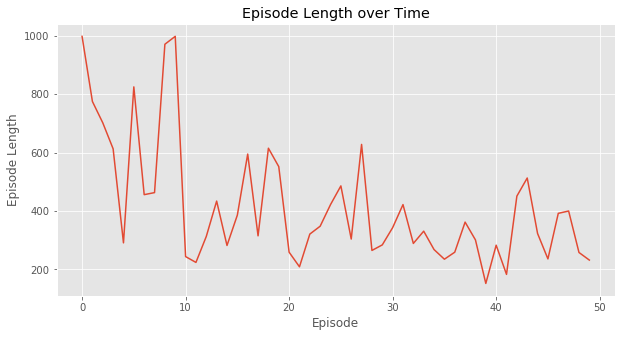

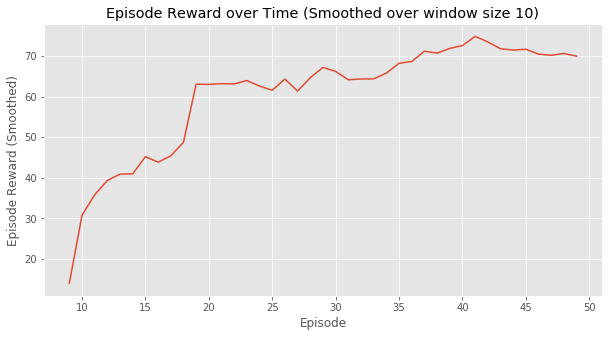

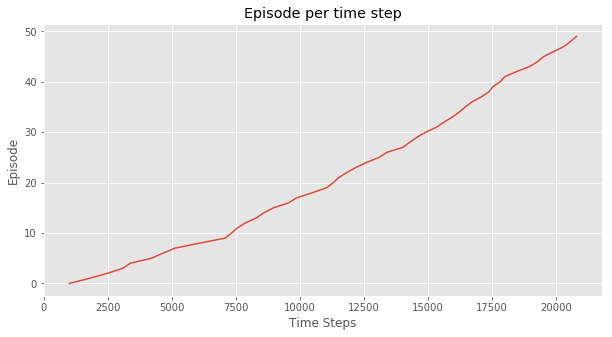

(<matplotlib.figure.Figure at 0x7f5689ff1510>,
 <matplotlib.figure.Figure at 0x7f5661750c90>)

In [10]:
plotting.plot_episode_stats(stats, smoothing_window=10)